In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib.patches import Ellipse

import numpy as np
from scipy.special import erfcinv
from scipy.stats import chi2, multivariate_normal, gamma
from scipy.special import erfinv, erf, erfc
from scipy.linalg import sqrtm, inv

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import git
import sys, os

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_global = os.path.dirname(path_git)
print('Path to git repo: {}'.format(path_global))

chi2_val = chi2.ppf(0.6827, df=2)

d = 2
L = 3  # Number of vector

Path to git repo: /home/matias/Documents/PhD/code


# Three moltivariate distributions

In [2]:
#Sharp triangle
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[1, 0.], [0., 1]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()



In [3]:
#Define some functions:

def calculate_R_CM(vectors):
    num_vectors = len(vectors)
    R_CM = np.sum(vectors, axis=0) / num_vectors
    return R_CM

def construct_K(vectors):
    num_vectors = len(vectors)

    R_CM = calculate_R_CM(vectors)

    K_xx = np.sum((vectors[:, 0] - R_CM[0]) ** 2)
    K_yy = np.sum((vectors[:, 1] - R_CM[1]) ** 2)
    K_xy = np.sum((vectors[:, 0] - R_CM[0]) * (vectors[:, 1] - R_CM[1]))
    K_yx = K_xy
    K = np.array([[K_xx, K_xy], [K_yx, K_yy]])
    return K

def construct_C(vectors):
    L = len(vectors)

    R_CM = calculate_R_CM(vectors)

    K_xx = np.sum((vectors[:, 0] - R_CM[0]) ** 2)
    K_yy = np.sum((vectors[:, 1] - R_CM[1]) ** 2)
    K_xy = np.sum((vectors[:, 0] - R_CM[0]) * (vectors[:, 1] - R_CM[1]))
    K_yx = K_xy
    #C = np.array([[K_xx, K_xy], [K_yx,K_yy]])/((L-1)*L)
    C = np.array([[K_xx, K_xy], [K_yx,K_yy]])/L
    return C

# Function to plot covariance matrix as an ellipse
def plot_covariance_matrix(ax, center, covariance, chi2_val, edgecolor='blue', alpha=0.5, n_std = 1 ):
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * n_std * np.sqrt(eigenvalues * chi2_val)  
    ellipse = Ellipse(xy=center, width=width, height=height, angle=angle, edgecolor=edgecolor, fc=edgecolor, alpha=alpha)
    return ellipse

In [4]:
def Q_tot_3data(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, num_samples=int(1e5)):

    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
    #r_4 = - r_1
    r_5 = - r_2
    r_6 = - r_3


    # Compute some statistic values:
    R_CM_123 = calculate_R_CM(np.array([r_1, r_2, r_3]))
    R_CM_126 = calculate_R_CM(np.array([r_1, r_2, r_6]))
    R_CM_153 = calculate_R_CM(np.array([r_1, r_5, r_3]))
    R_CM_156 = calculate_R_CM(np.array([r_1, r_5, r_6]))


    samps_A_H0 = np.random.multivariate_normal(0*mean_A, cov_A, size=num_samples)
    samps_B_H0 = np.random.multivariate_normal(0*mean_B, cov_B, size=num_samples)
    samps_C_H0 = np.random.multivariate_normal(0*mean_C, cov_C, size=num_samples)

    samps_delta_theta_AB_H0 = samps_A_H0 - samps_B_H0
    samps_delta_theta_AC_H0 = samps_A_H0 - samps_C_H0
    samps_delta_theta_BC_H0 = samps_B_H0 - samps_C_H0

    R_samples_H0_123 = np.zeros(num_samples)
    R_samples_H0_126 = np.zeros(num_samples)
    R_samples_H0_153 = np.zeros(num_samples)
    R_samples_H0_156 = np.zeros(num_samples)
    for i in range(len(R_samples_H0_123)):
        r_1_H0 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (samps_delta_theta_AB_H0[i,:]))
        r_2_H0 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (samps_delta_theta_AC_H0[i,:]))
        r_3_H0 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (samps_delta_theta_BC_H0[i,:]))
        #r_4_H0 = - r_1_H0
        r_5_H0 = - r_2_H0
        r_6_H0 = - r_3_H0

        vectors_H0_123 = np.array([r_1_H0, r_2_H0, r_3_H0])
        R_CM_H0_123 = calculate_R_CM(vectors_H0_123)
        R_samples_H0_123[i] = np.linalg.norm(R_CM_H0_123)**2

        vectors_H0_126 = np.array([r_1_H0, r_2_H0, r_6_H0])
        R_CM_H0_126 = calculate_R_CM(vectors_H0_126)
        R_samples_H0_126[i] = np.linalg.norm(R_CM_H0_126)**2

        vectors_H0_153 = np.array([r_1_H0, r_5_H0, r_3_H0])
        R_CM_H0_153 = calculate_R_CM(vectors_H0_153)
        R_samples_H0_153[i] = np.linalg.norm(R_CM_H0_153)**2

        vectors_H0_156 = np.array([r_1_H0, r_5_H0, r_6_H0])
        R_CM_H0_156 = calculate_R_CM(vectors_H0_156)
        R_samples_H0_156[i] = np.linalg.norm(R_CM_H0_156)**2

    PTE = R_samples_H0_123[R_samples_H0_123 > np.linalg.norm(R_CM_123)**2].size/R_samples_H0_123.size
    N_sigma_Q_123 = np.sqrt(2) * erfcinv(PTE)

    PTE = R_samples_H0_126[R_samples_H0_126 > np.linalg.norm(R_CM_126)**2].size/R_samples_H0_126.size
    N_sigma_Q_126 = np.sqrt(2) * erfcinv(PTE)

    PTE = R_samples_H0_153[R_samples_H0_153 > np.linalg.norm(R_CM_153)**2].size/R_samples_H0_153.size
    N_sigma_Q_153 = np.sqrt(2) * erfcinv(PTE)

    PTE = R_samples_H0_156[R_samples_H0_156 > np.linalg.norm(R_CM_156)**2].size/R_samples_H0_156.size
    N_sigma_Q_156 = np.sqrt(2) * erfcinv(PTE)

    return N_sigma_Q_123, N_sigma_Q_126, N_sigma_Q_153, N_sigma_Q_156


In [5]:
def plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title, name_plot, reversed=False, png=True):

    names = ['x', 'y']
    labels = ['x', 'y']

    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
    r_4 = - r_1
    r_5 = - r_2
    r_6 = - r_3

    # Example usage:
    R_CM_123 = calculate_R_CM(np.array([r_1, r_2, r_3]))
    R_CM_126 = calculate_R_CM(np.array([r_1, r_2, r_6]))
    R_CM_153 = calculate_R_CM(np.array([r_1, r_5, r_3]))
    R_CM_156 = calculate_R_CM(np.array([r_1, r_5, r_6]))

    R_CM_423 = calculate_R_CM(np.array([r_4, r_2, r_3]))
    R_CM_426 = calculate_R_CM(np.array([r_4, r_2, r_6]))
    R_CM_453 = calculate_R_CM(np.array([r_4, r_5, r_3]))
    R_CM_456 = calculate_R_CM(np.array([r_4, r_5, r_6]))

    # Example usage:
    C_123 = construct_C(np.array([r_1, r_2, r_3]))
    C_126 = construct_C(np.array([r_1, r_2, r_6]))
    C_153 = construct_C(np.array([r_1, r_5, r_3]))
    C_156 = construct_C(np.array([r_1, r_5, r_6]))

    C_423 = construct_C(np.array([r_4, r_2, r_3]))
    C_426 = construct_C(np.array([r_4, r_2, r_6]))
    C_453 = construct_C(np.array([r_4, r_5, r_3]))
    C_456 = construct_C(np.array([r_4, r_5, r_6]))

    r_s = np.array([r_1, r_2, r_3, r_4, r_5, r_6])
    r_s_dic = np.array(['AB', 'AC', 'BC', 'BA', 'CA', 'CB'])

    R_CMs = [R_CM_123, R_CM_126, R_CM_153, R_CM_156]
    R_CMs_rev = [R_CM_423, R_CM_426, R_CM_453, R_CM_456]
    Cs = [C_123, C_126, C_153, C_156]
    Cs_rev = [C_423, C_426, C_453, C_456]

    lim_x = np.array([-10, 10])
    lim_y = np.array([-10, 10])

    samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
    samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
    samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

    chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
    chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
    chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

    colors = ['red', 'blue', 'green']

    g = plots.get_subplot_plotter()
    g.triangle_plot([chain_A, chain_B, chain_C],\
                    filled=True, contour_args={'alpha':0.5},\
                    contour_colors=colors,
                    legend_labels=['A', 'B', 'C'])
    os.chdir(os.path.join(path_git, 'notebooks','PRL', 'tests', 'figures'))
    if png==True:
        g.export('dist_{}.png'.format(name_plot))
    else:
        g.export('dist_{}.pdf'.format(name_plot))


    fig, axes = plt.subplots(2,2, figsize=(14,10))
    fig.suptitle(title)

    for ax in axes.flatten():
        ax.set_xlabel(r'$\Delta x$',size=14)
        ax.set_ylabel(r'$\Delta y$',size=14)
        ax.hlines(0, lim_x[0], lim_x[1], color='black', lw=0.5)
        ax.vlines(0, lim_y[0], lim_y[1], color='black', lw=0.5)


    if reversed == False:
        # 0,0
        axes[0, 0].quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
        axes[0, 0].quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
        axes[0, 0].quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

        axes[0, 0].scatter([r_1[0], r_2[0], r_3[0]], [r_1[1], r_2[1], r_3[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
        axes[0, 0].scatter([R_CM_123[0]], [R_CM_123[1]], color='black')#, label='CM')

        axes[0, 0].quiver(R_CM_123[0], R_CM_123[1], np.linalg.eig(C_123)[1][0, 0], np.linalg.eig(C_123)[1][1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(np.linalg.eig(C_123)[0][0]))
        axes[0, 0].quiver(R_CM_123[0], R_CM_123[1], np.linalg.eig(C_123)[1][0, 1], np.linalg.eig(C_123)[1][1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(np.linalg.eig(C_123)[0][1]))

        axes[0, 0].text(r_1[0]-0.5, r_1[1]+0.2, 'AB', size=10)
        axes[0, 0].text(r_2[0]-0.2, r_2[1]-0.3, 'AC')
        axes[0, 0].text(r_3[0]-0.0, r_3[1]-0.3, 'BC')

        axes[0, 0].set_xlim(*lim_x)
        axes[0, 0].set_ylim(*lim_y)

        axes[0, 0].legend()
        axes[0, 0].grid()


        # 0,1
        axes[0, 1].quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
        axes[0, 1].quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
        axes[0, 1].quiver(0, 0, r_6[0], r_6[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
        axes[0, 1].scatter([r_1[0], r_2[0], r_6[0]], [r_1[1], r_2[1], r_6[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
        axes[0, 1].scatter([R_CM_126[0]], [R_CM_126[1]], color='black')#, label='CM')
        axes[0, 1].quiver(R_CM_126[0], R_CM_126[1], np.linalg.eig(C_126)[1][0, 0], np.linalg.eig(C_126)[1][1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(np.linalg.eig(C_126)[0][0]))
        axes[0, 1].quiver(R_CM_126[0], R_CM_126[1], np.linalg.eig(C_126)[1][0, 1], np.linalg.eig(C_126)[1][1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(np.linalg.eig(C_126)[0][1]))

        axes[0, 1].text(r_1[0]-0.5, r_1[1]+0.2, 'AB', size=10)
        axes[0, 1].text(r_2[0]-0.2, r_2[1]-0.3, 'AC')
        axes[0, 1].text(r_6[0]-0.0, r_6[1]-0.3, 'CB')
        axes[0, 1].set_xlim(*lim_x)
        axes[0, 1].set_ylim(*lim_y)
        axes[0, 1].grid()
        axes[0, 1].legend()


        # 1,0
        axes[1, 0].quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
        axes[1, 0].quiver(0, 0, r_5[0], r_5[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
        axes[1, 0].quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
        axes[1, 0].scatter([r_1[0], r_5[0], r_3[0]], [r_1[1], r_5[1], r_3[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
        axes[1, 0].scatter([R_CM_153[0]], [R_CM_153[1]], color='black')#, label='CM')

        axes[1, 0].quiver(R_CM_153[0], R_CM_153[1], np.linalg.eig(C_153)[1][0, 0], np.linalg.eig(C_153)[1][1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(np.linalg.eig(C_153)[0][0]))
        axes[1, 0].quiver(R_CM_153[0], R_CM_153[1], np.linalg.eig(C_153)[1][0, 1], np.linalg.eig(C_153)[1][1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(np.linalg.eig(C_153)[0][1]))

        axes[1, 0].text(r_1[0]-0.5, r_1[1]+0.2, 'AB', size=10)
        axes[1, 0].text(r_5[0]-0.2, r_5[1]-0.3, 'CA')
        axes[1, 0].text(r_3[0]-0.0, r_3[1]-0.3, 'BC')
        axes[1, 0].set_xlim(*lim_x)
        axes[1, 0].set_ylim(*lim_y)
        axes[1, 0].grid()
        axes[1, 0].legend()


        # 1,1
        axes[1, 1].quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
        axes[1, 1].quiver(0, 0, r_5[0], r_5[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
        axes[1, 1].quiver(0, 0, r_6[0], r_6[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

        axes[1, 1].scatter([r_1[0], r_5[0], r_6[0]], [r_1[1], r_5[1], r_6[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
        axes[1, 1].scatter([R_CM_156[0]], [R_CM_156[1]], color='black')#, label='CM')
        axes[1, 1].quiver(R_CM_156[0], R_CM_156[1], np.linalg.eig(C_156)[1][0, 0], np.linalg.eig(C_156)[1][1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(np.linalg.eig(C_156)[0][0]))
        axes[1, 1].quiver(R_CM_156[0], R_CM_156[1], np.linalg.eig(C_156)[1][0, 1], np.linalg.eig(C_156)[1][1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(np.linalg.eig(C_156)[0][1]))
        axes[1, 1].text(r_1[0]-0.5, r_1[1]+0.2, 'AB', size=10)
        axes[1, 1].text(r_5[0]-0.2, r_5[1]-0.3, 'CA')
        axes[1, 1].text(r_6[0]-0.0, r_6[1]-0.3, 'CB')
        axes[1, 1].set_xlim(*lim_x)
        axes[1, 1].set_ylim(*lim_y)
        axes[1, 1].grid()


    elif reversed == True:
        # 0,0
        axes[0, 0].quiver(0, 0, r_4[0], r_4[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
        axes[0, 0].quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
        axes[0, 0].quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

        axes[0, 0].scatter([r_4[0], r_2[0], r_3[0]], [r_4[1], r_2[1], r_3[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
        axes[0, 0].scatter([R_CM_423[0]], [R_CM_423[1]], color='black')#, label='CM')

        axes[0, 0].quiver(R_CM_423[0], R_CM_423[1], np.linalg.eig(C_423)[1][0, 0], np.linalg.eig(C_423)[1][1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(np.linalg.eig(C_423)[0][0]))
        axes[0, 0].quiver(R_CM_423[0], R_CM_423[1], np.linalg.eig(C_423)[1][0, 1], np.linalg.eig(C_423)[1][1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(np.linalg.eig(C_423)[0][1]))

        axes[0, 0].text(r_4[0]-0.5, r_4[1]+0.2, 'BA', size=10)
        axes[0, 0].text(r_2[0]-0.2, r_2[1]-0.3, 'AC')
        axes[0, 0].text(r_3[0]-0.0, r_3[1]-0.3, 'BC')

        axes[0, 0].set_xlim(*lim_x)
        axes[0, 0].set_ylim(*lim_y)

        axes[0, 0].legend()
        axes[0, 0].grid()


        # 0,1
        axes[0, 1].quiver(0, 0, r_4[0], r_4[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
        axes[0, 1].quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
        axes[0, 1].quiver(0, 0, r_6[0], r_6[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
        axes[0, 1].scatter([r_4[0], r_2[0], r_6[0]], [r_4[1], r_2[1], r_6[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
        axes[0, 1].scatter([R_CM_426[0]], [R_CM_426[1]], color='black')#, label='CM')
        axes[0, 1].quiver(R_CM_426[0], R_CM_426[1], np.linalg.eig(C_426)[1][0, 0], np.linalg.eig(C_426)[1][1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(np.linalg.eig(C_426)[0][0]))
        axes[0, 1].quiver(R_CM_426[0], R_CM_426[1], np.linalg.eig(C_426)[1][0, 1], np.linalg.eig(C_426)[1][1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(np.linalg.eig(C_426)[0][1]))

        axes[0, 1].text(r_4[0]-0.5, r_4[1]+0.2, 'BA', size=10)
        axes[0, 1].text(r_2[0]-0.2, r_2[1]-0.3, 'AC')
        axes[0, 1].text(r_6[0]-0.0, r_6[1]-0.3, 'CB')
        axes[0, 1].set_xlim(*lim_x)
        axes[0, 1].set_ylim(*lim_y)
        axes[0, 1].grid()
        axes[0, 1].legend()


        # 1,0
        axes[1, 0].quiver(0, 0, r_4[0], r_4[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
        axes[1, 0].quiver(0, 0, r_5[0], r_5[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
        axes[1, 0].quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
        axes[1, 0].scatter([r_4[0], r_5[0], r_3[0]], [r_4[1], r_5[1], r_3[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
        axes[1, 0].scatter([R_CM_453[0]], [R_CM_453[1]], color='black')#, label='CM')

        axes[1, 0].quiver(R_CM_453[0], R_CM_453[1], np.linalg.eig(C_453)[1][0, 0], np.linalg.eig(C_453)[1][1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(np.linalg.eig(C_453)[0][0]))
        axes[1, 0].quiver(R_CM_453[0], R_CM_453[1], np.linalg.eig(C_453)[1][0, 1], np.linalg.eig(C_453)[1][1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(np.linalg.eig(C_453)[0][1]))

        axes[1, 0].text(r_4[0]-0.5, r_4[1]+0.2, 'BA', size=10)
        axes[1, 0].text(r_5[0]-0.2, r_5[1]-0.3, 'CA')
        axes[1, 0].text(r_3[0]-0.0, r_3[1]-0.3, 'BC')
        axes[1, 0].set_xlim(*lim_x)
        axes[1, 0].set_ylim(*lim_y)
        axes[1, 0].grid()
        axes[1, 0].legend()


        # 1,1
        axes[1, 1].quiver(0, 0, r_4[0], r_4[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
        axes[1, 1].quiver(0, 0, r_5[0], r_5[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
        axes[1, 1].quiver(0, 0, r_6[0], r_6[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

        axes[1, 1].scatter([r_4[0], r_5[0], r_6[0]], [r_4[1], r_5[1], r_6[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
        axes[1, 1].scatter([R_CM_456[0]], [R_CM_456[1]], color='black')#, label='CM')
        axes[1, 1].quiver(R_CM_456[0], R_CM_456[1], np.linalg.eig(C_456)[1][0, 0], np.linalg.eig(C_456)[1][1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(np.linalg.eig(C_456)[0][0]))
        axes[1, 1].quiver(R_CM_456[0], R_CM_456[1], np.linalg.eig(C_456)[1][0, 1], np.linalg.eig(C_456)[1][1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(np.linalg.eig(C_456)[0][1]))
        axes[1, 1].text(r_4[0]-0.5, r_4[1]+0.2, 'BA', size=10)
        axes[1, 1].text(r_5[0]-0.2, r_5[1]-0.3, 'CA')
        axes[1, 1].text(r_6[0]-0.0, r_6[1]-0.3, 'CB')
        axes[1, 1].set_xlim(*lim_x)
        axes[1, 1].set_ylim(*lim_y)
        axes[1, 1].grid()



    for i, ax in enumerate(axes.flatten()):
        # Para mostrar ambas leyendas en la parte inferior, puedes usar handles y labels manualmente:
        handles1, labels1 = ax.get_legend_handles_labels()
        legend1 = ax.legend(handles=handles1, labels=labels1, loc='lower left', fontsize=12)
        ax.add_artist(legend1)

        legend2 = ax.legend(
            [f'Det = {np.prod(np.linalg.eigvals(Cs_rev[i])):.3g}', 
            f'Tr = {np.sum(np.linalg.eigvals(Cs_rev[i])):.3g}',
            f'RCM^2 = {np.linalg.norm(R_CMs_rev[i])**2:.3g}',
            f'Tr+RCM^2 = {np.sum(np.linalg.eigvals(Cs_rev[i])) + np.linalg.norm(R_CMs_rev[i])**2:.3g}',
            f'min/max = {np.min(np.linalg.eigvals(Cs_rev[i])) / np.max(np.linalg.eigvals(Cs_rev[i])):.3g}'],
            loc='lower right', fontsize=9, title='Properties'
        )

    if reversed == False:
        os.chdir(os.path.join(path_git, 'notebooks','PRL', 'tests', 'figures'))
        if png==True:
            fig.savefig('geom_{}.png'.format(name_plot), dpi=300, bbox_inches='tight')
        else:
            fig.savefig('geom_{}.pdf'.format(name_plot), dpi=300, bbox_inches='tight')
        plt.show()

    elif reversed == True:
        os.chdir(os.path.join(path_git, 'notebooks','PRL', 'tests', 'figures'))
        if png==True:
            fig.savefig('geom_{}_rev.png'.format(name_plot), dpi=300, bbox_inches='tight')
        else:
            fig.savefig('geom_{}_rev.pdf'.format(name_plot), dpi=300, bbox_inches='tight')
        plt.show()

# Case 1

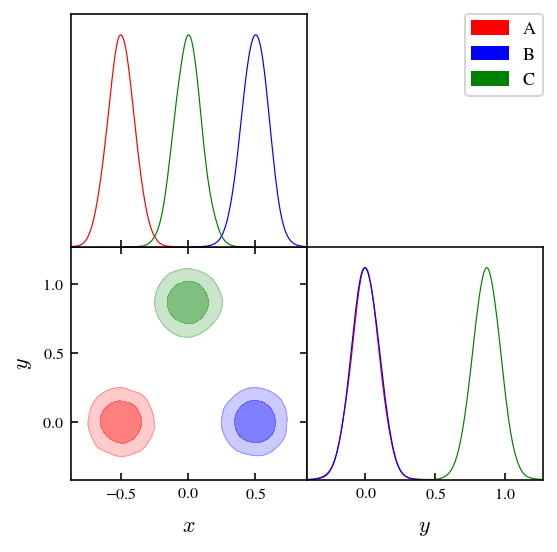

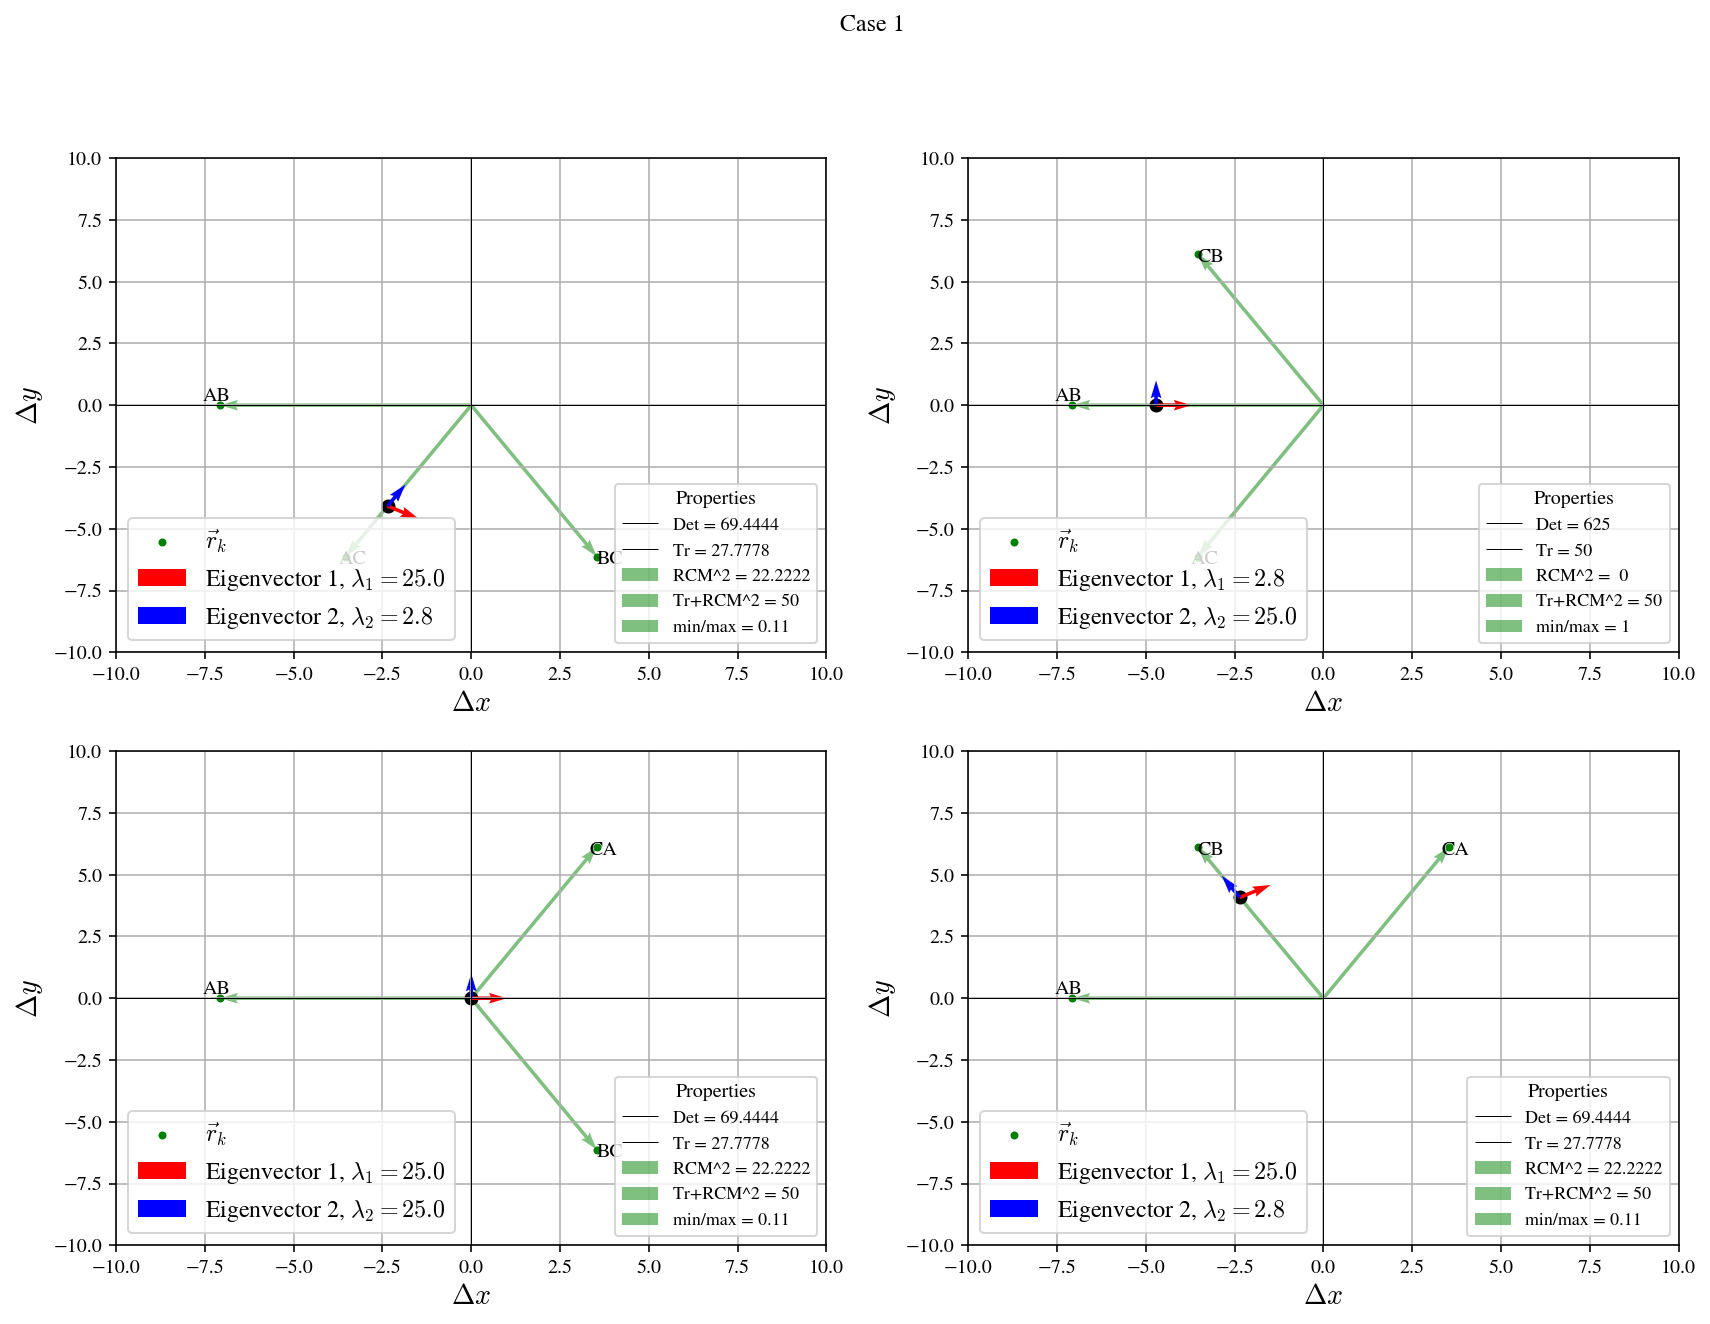

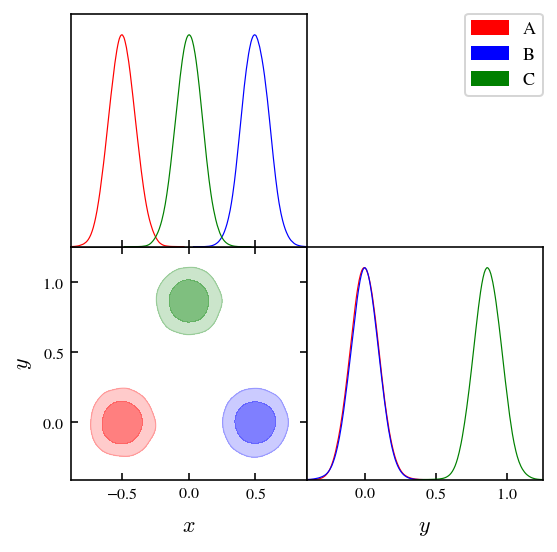

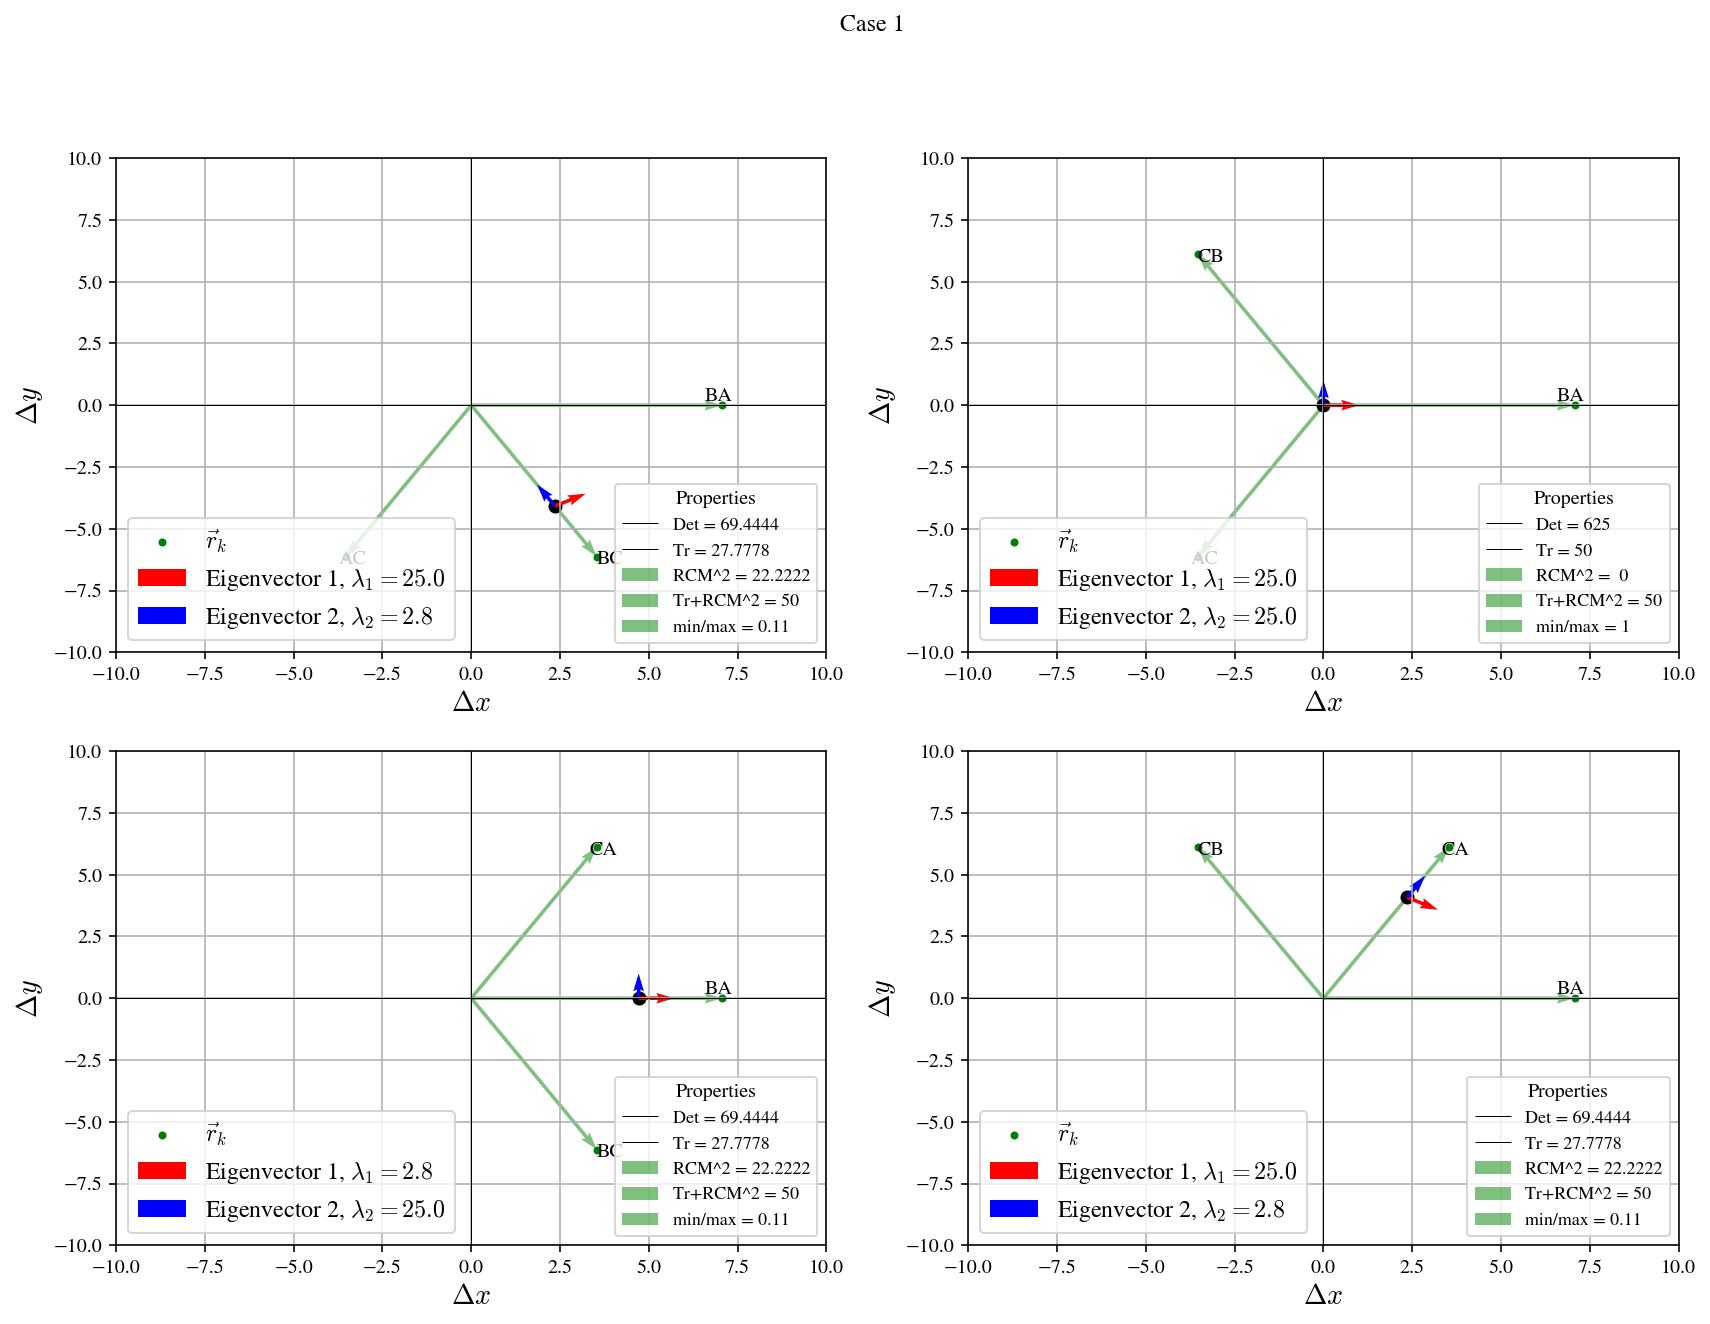

In [6]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title='Case 1', name_plot='1')
plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title='Case 1', name_plot='1', reversed=True)


# Case 2

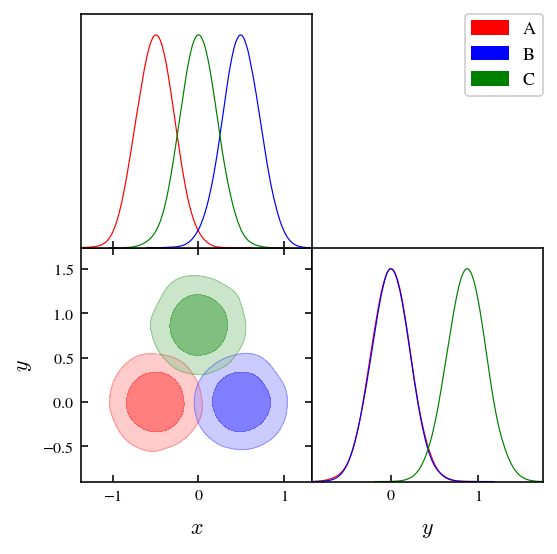

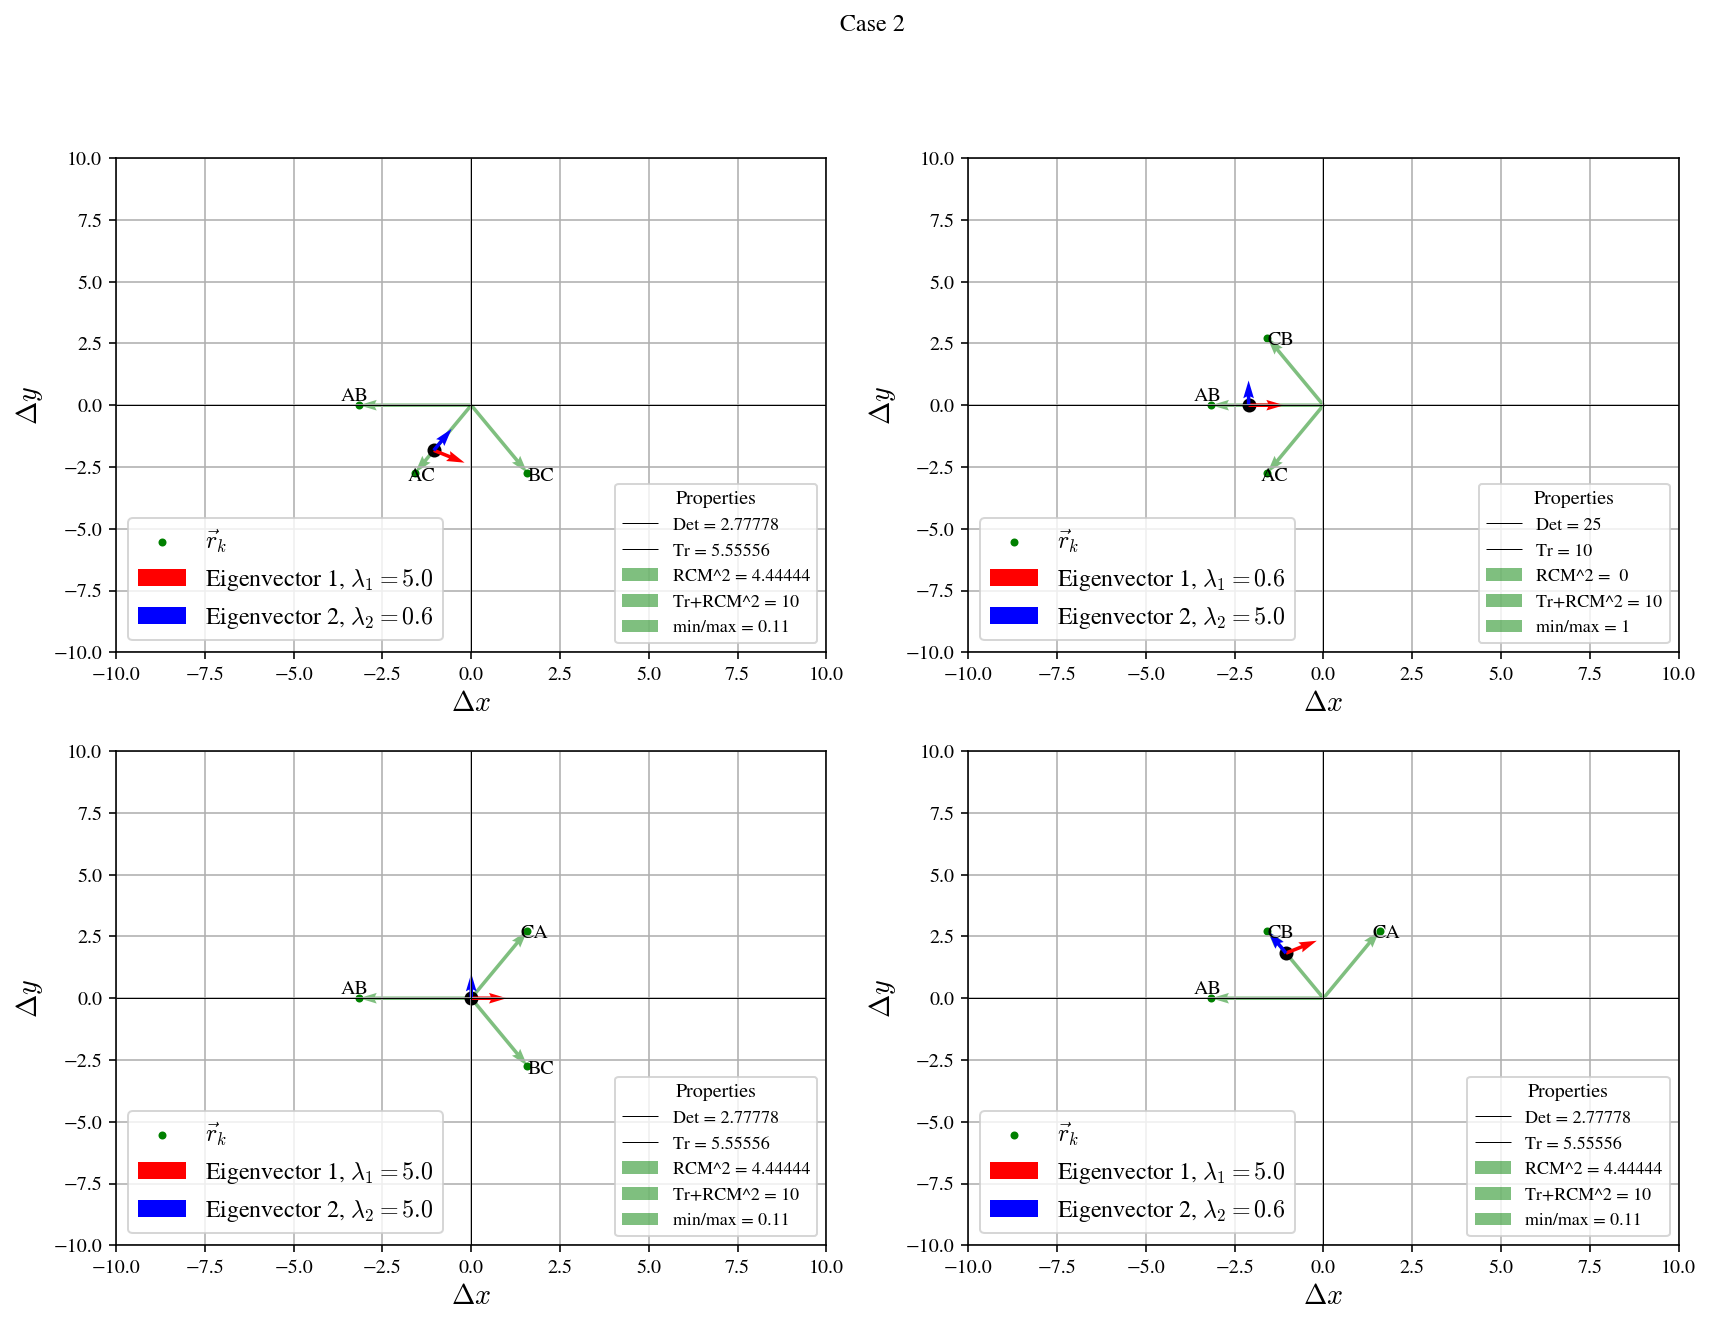

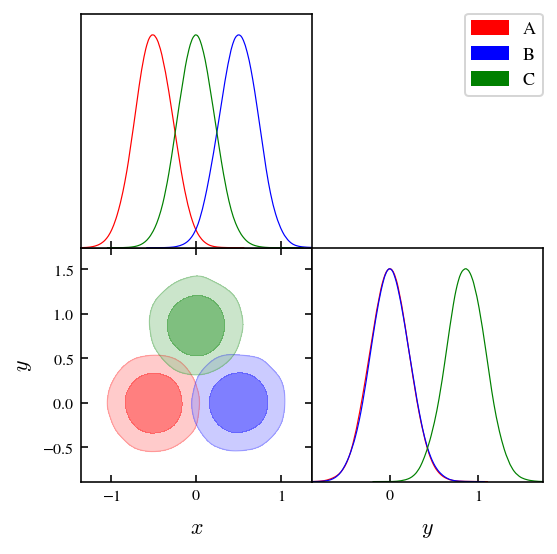

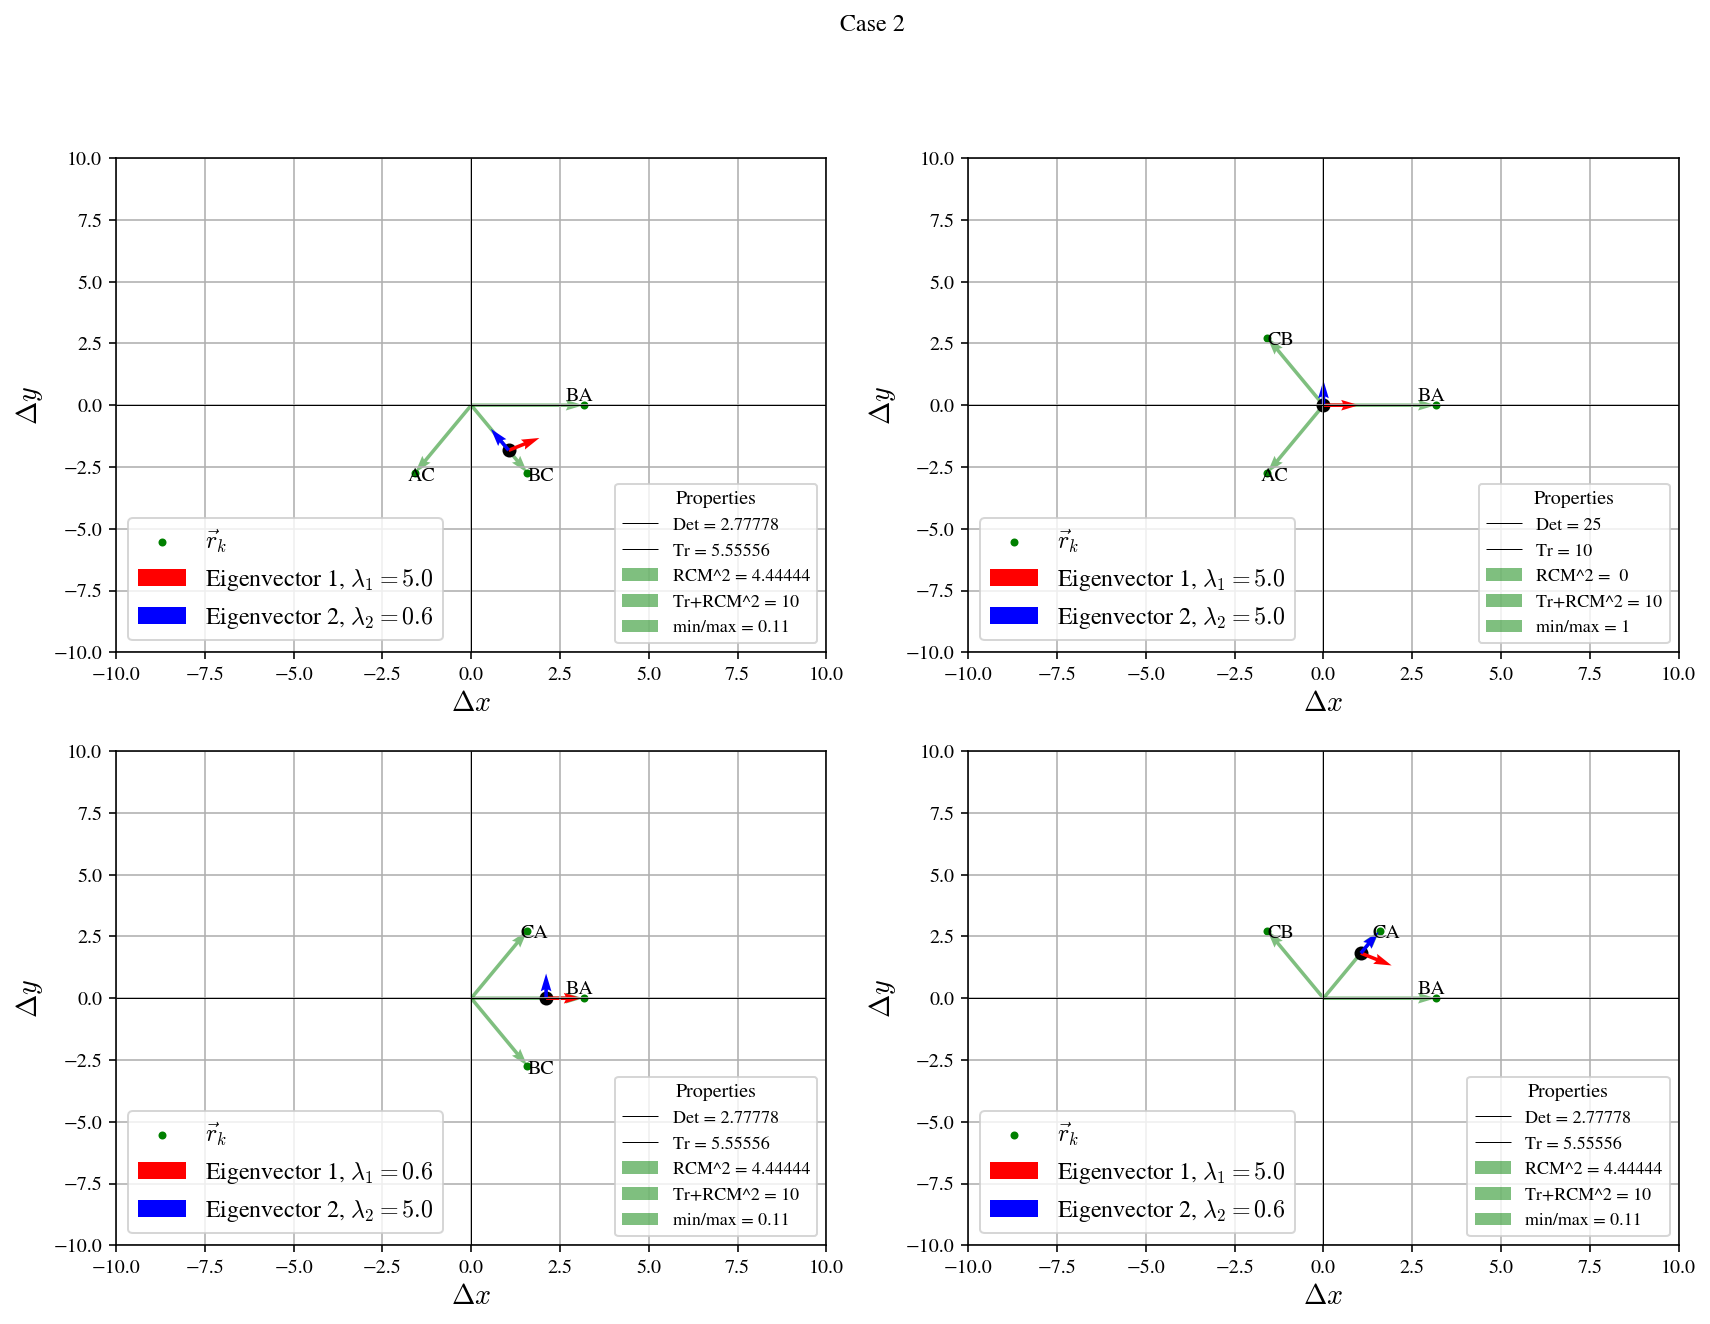

In [7]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = 5*np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()


r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title='Case 2', name_plot='2')
plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title='Case 2', name_plot='2', reversed=True)

# Case Susana 1

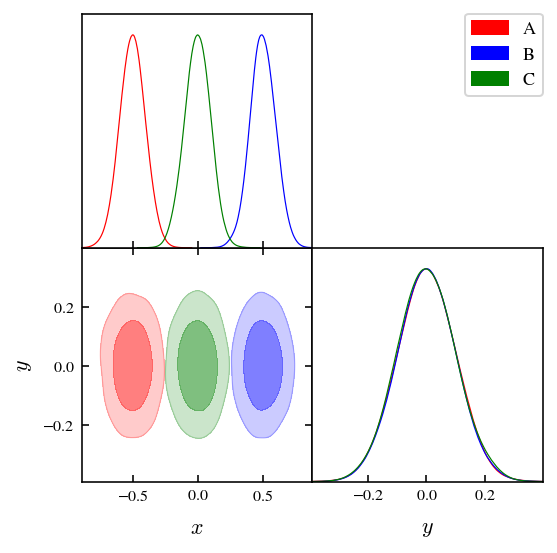

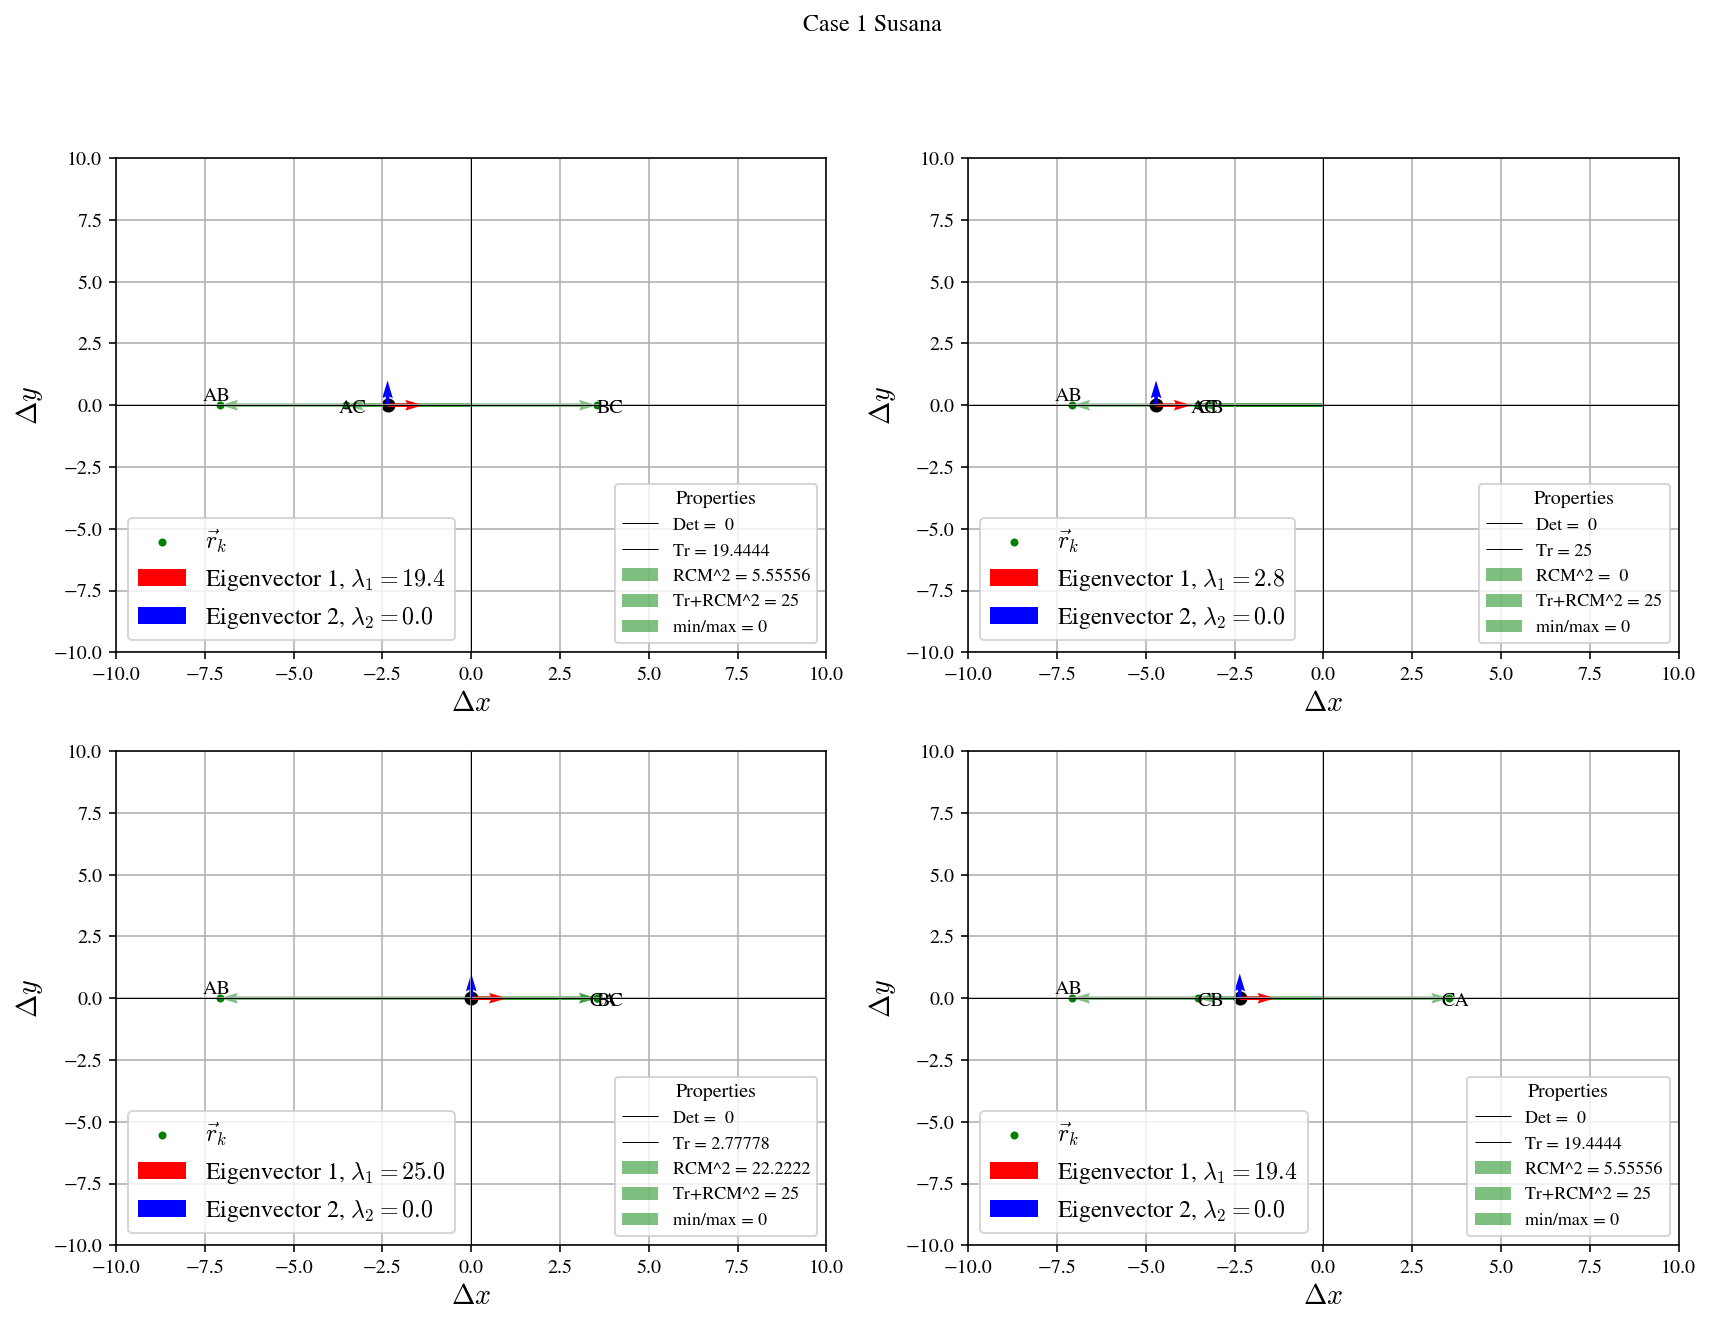

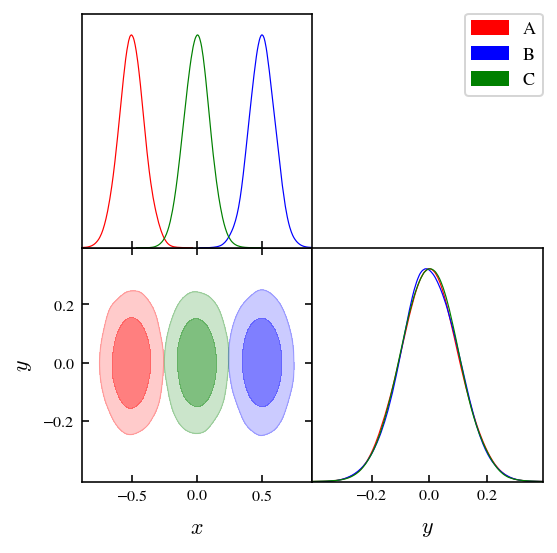

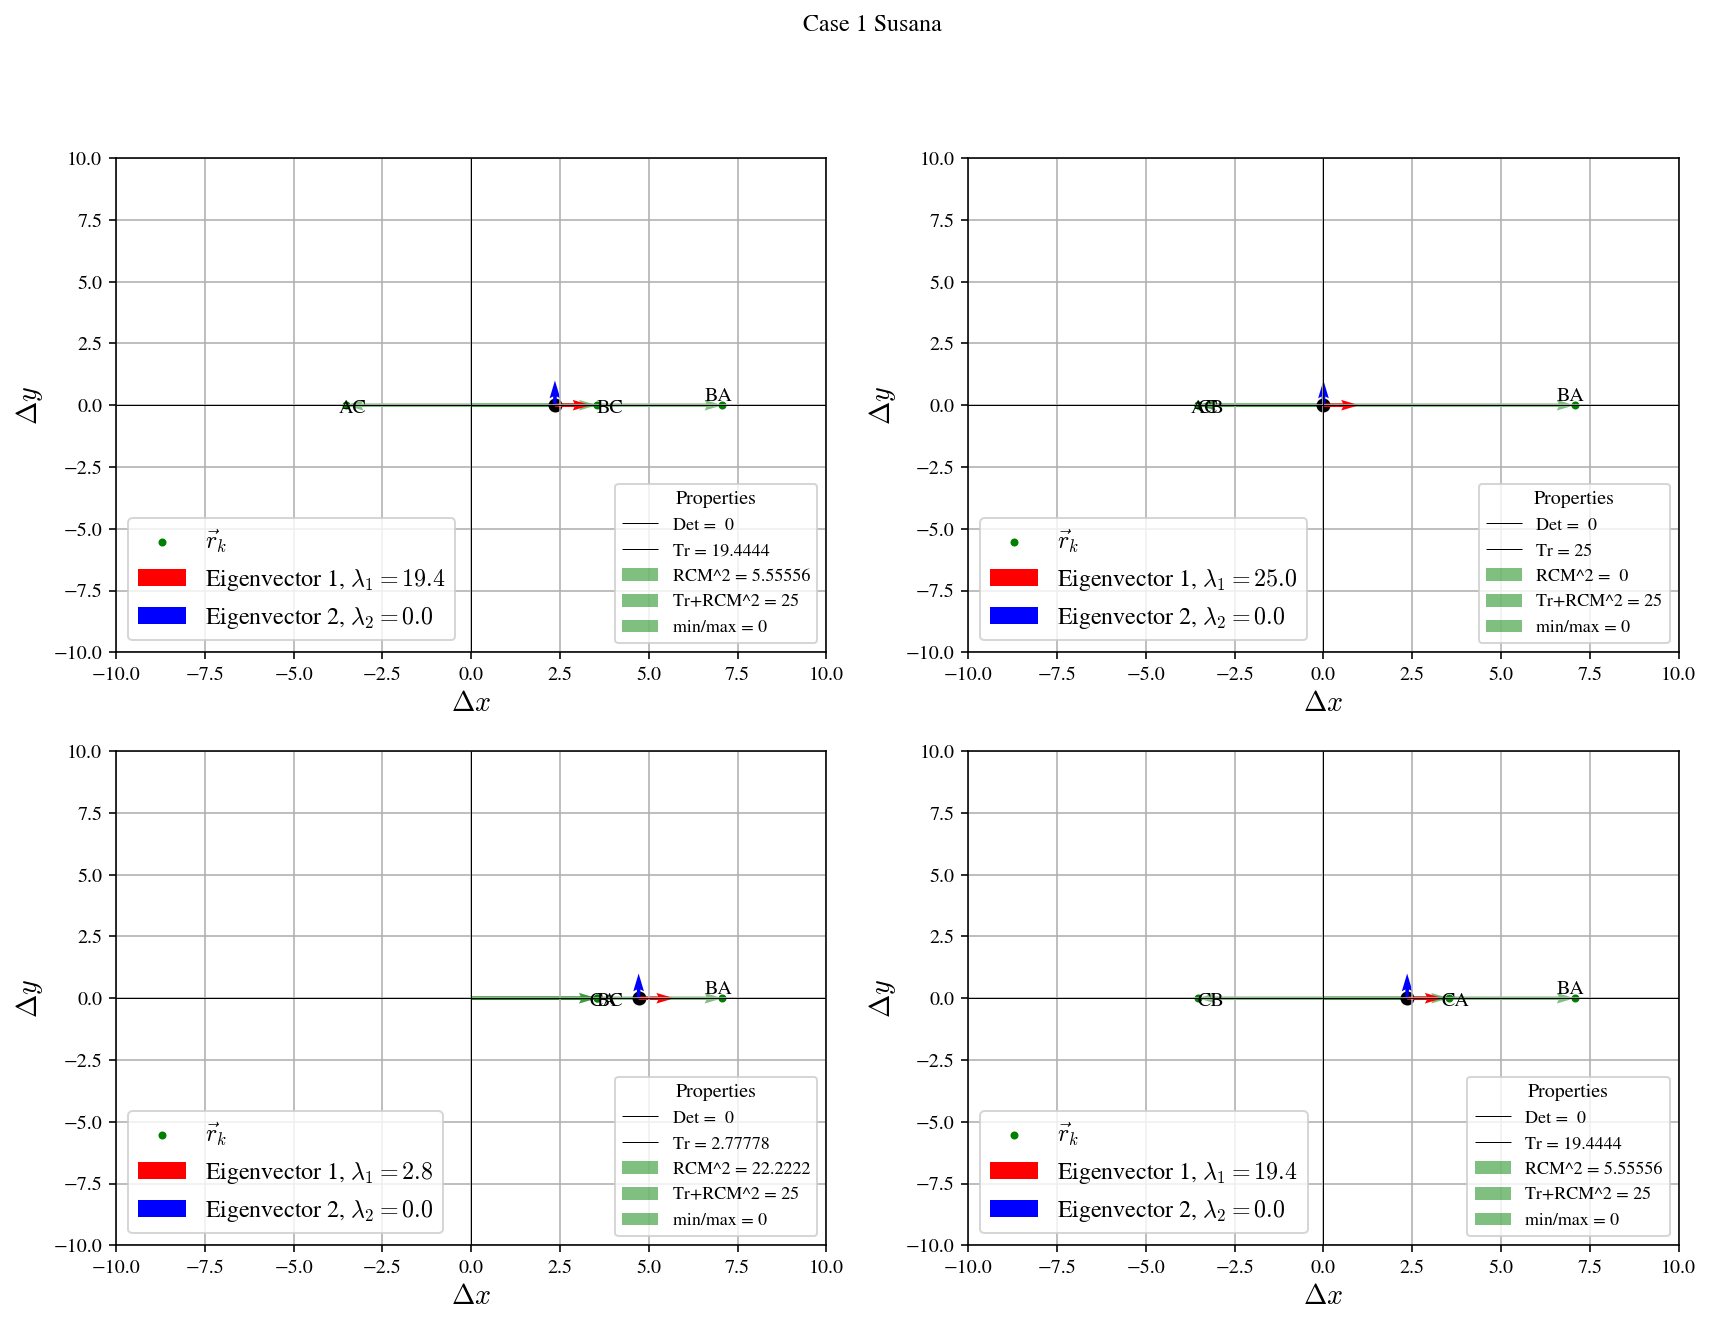

In [14]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, 0.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()


r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title='Case 1 Susana', name_plot='susana_1')
plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title='Case 1 Susana', name_plot='susana_1', reversed=True)

# Case Susana 2

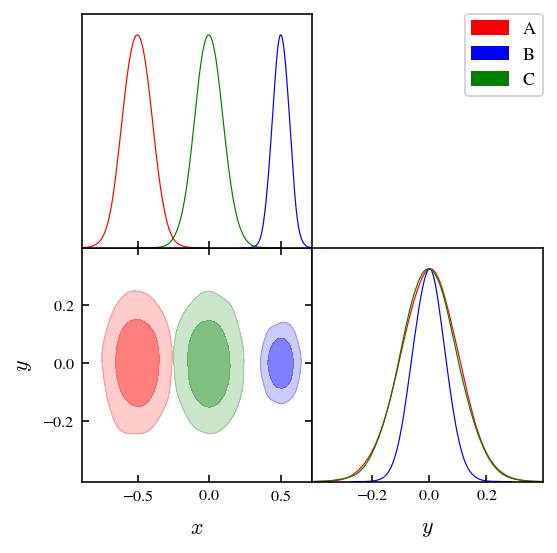

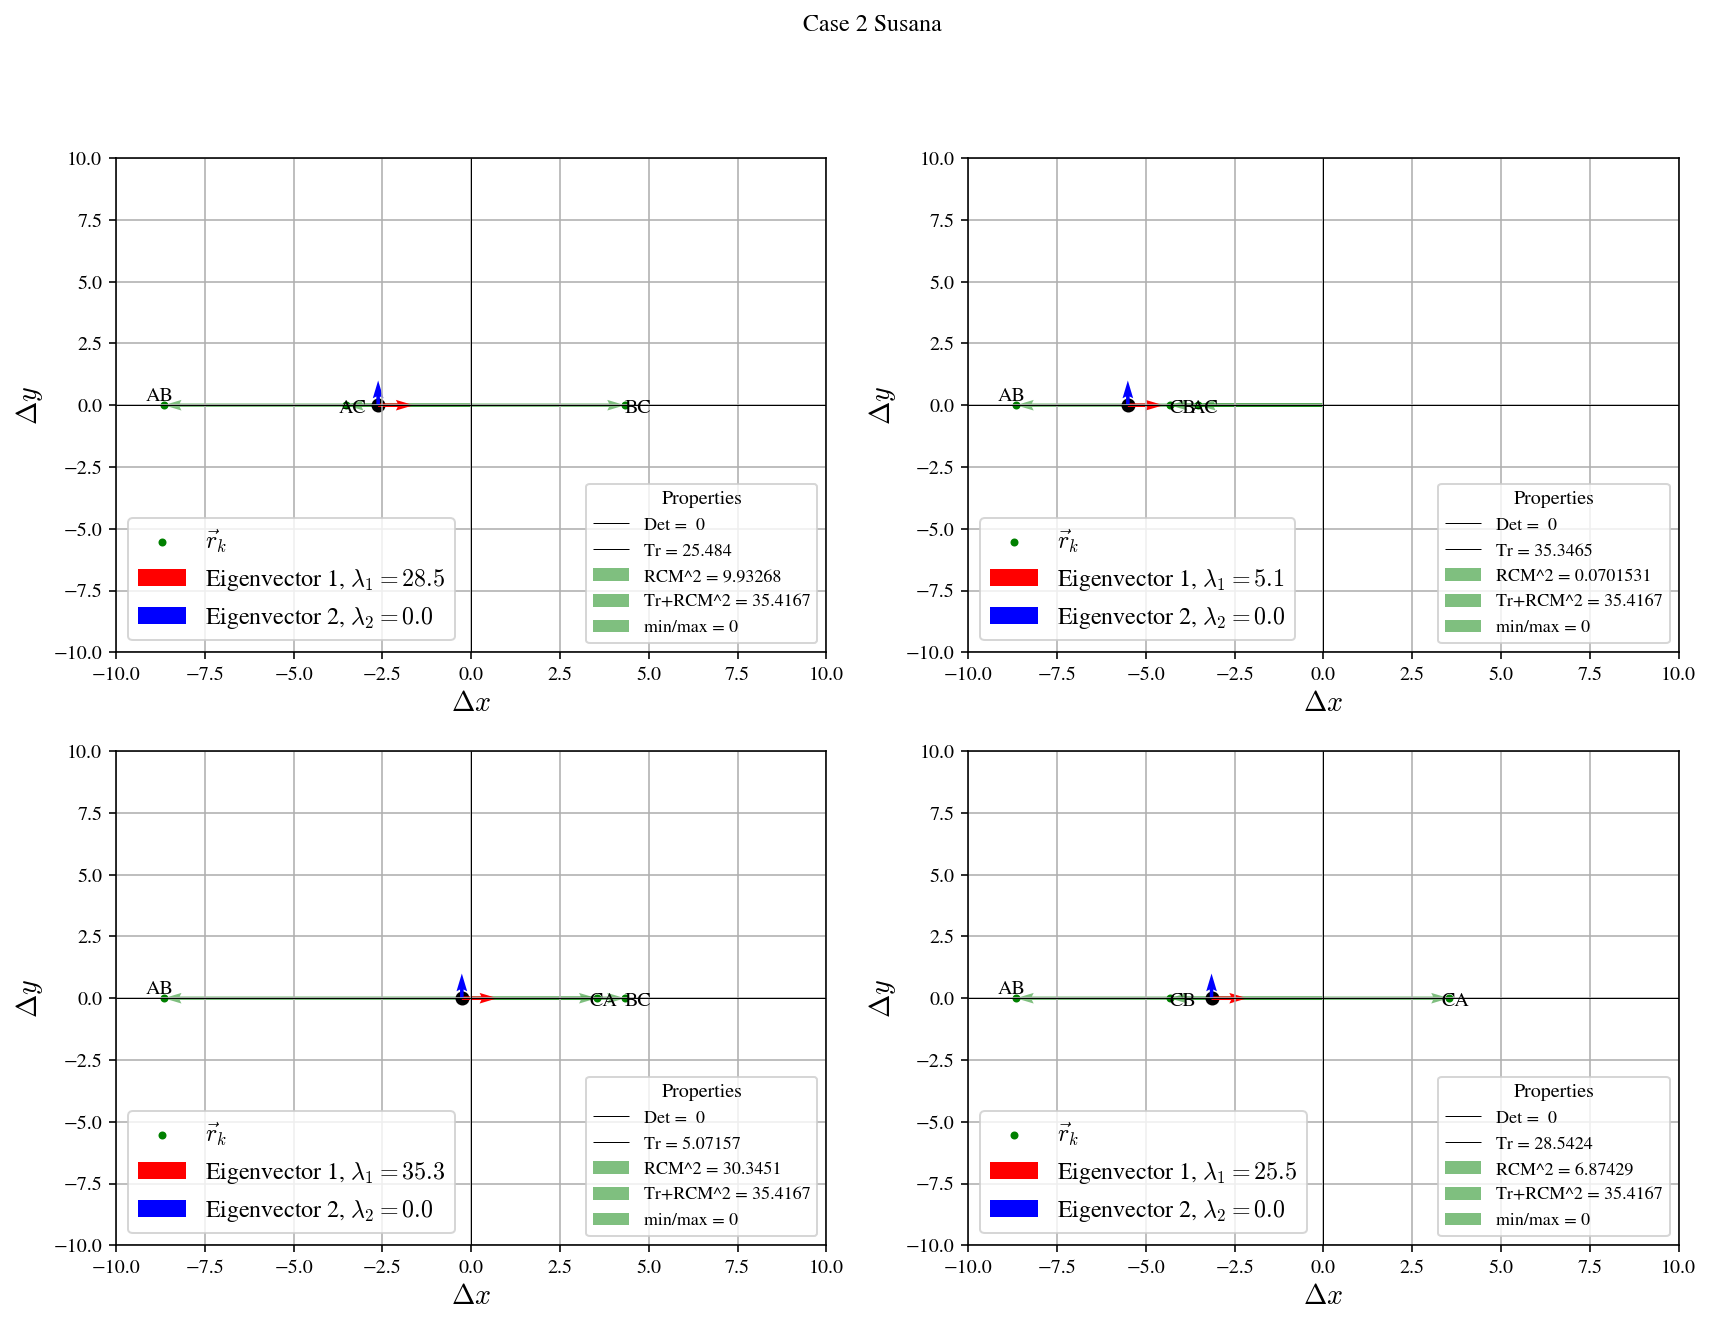

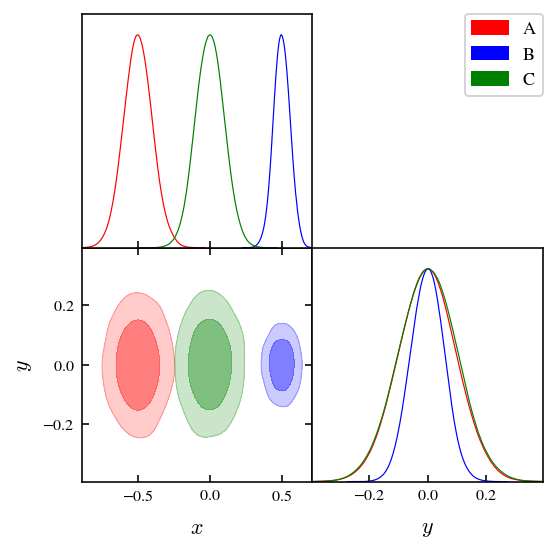

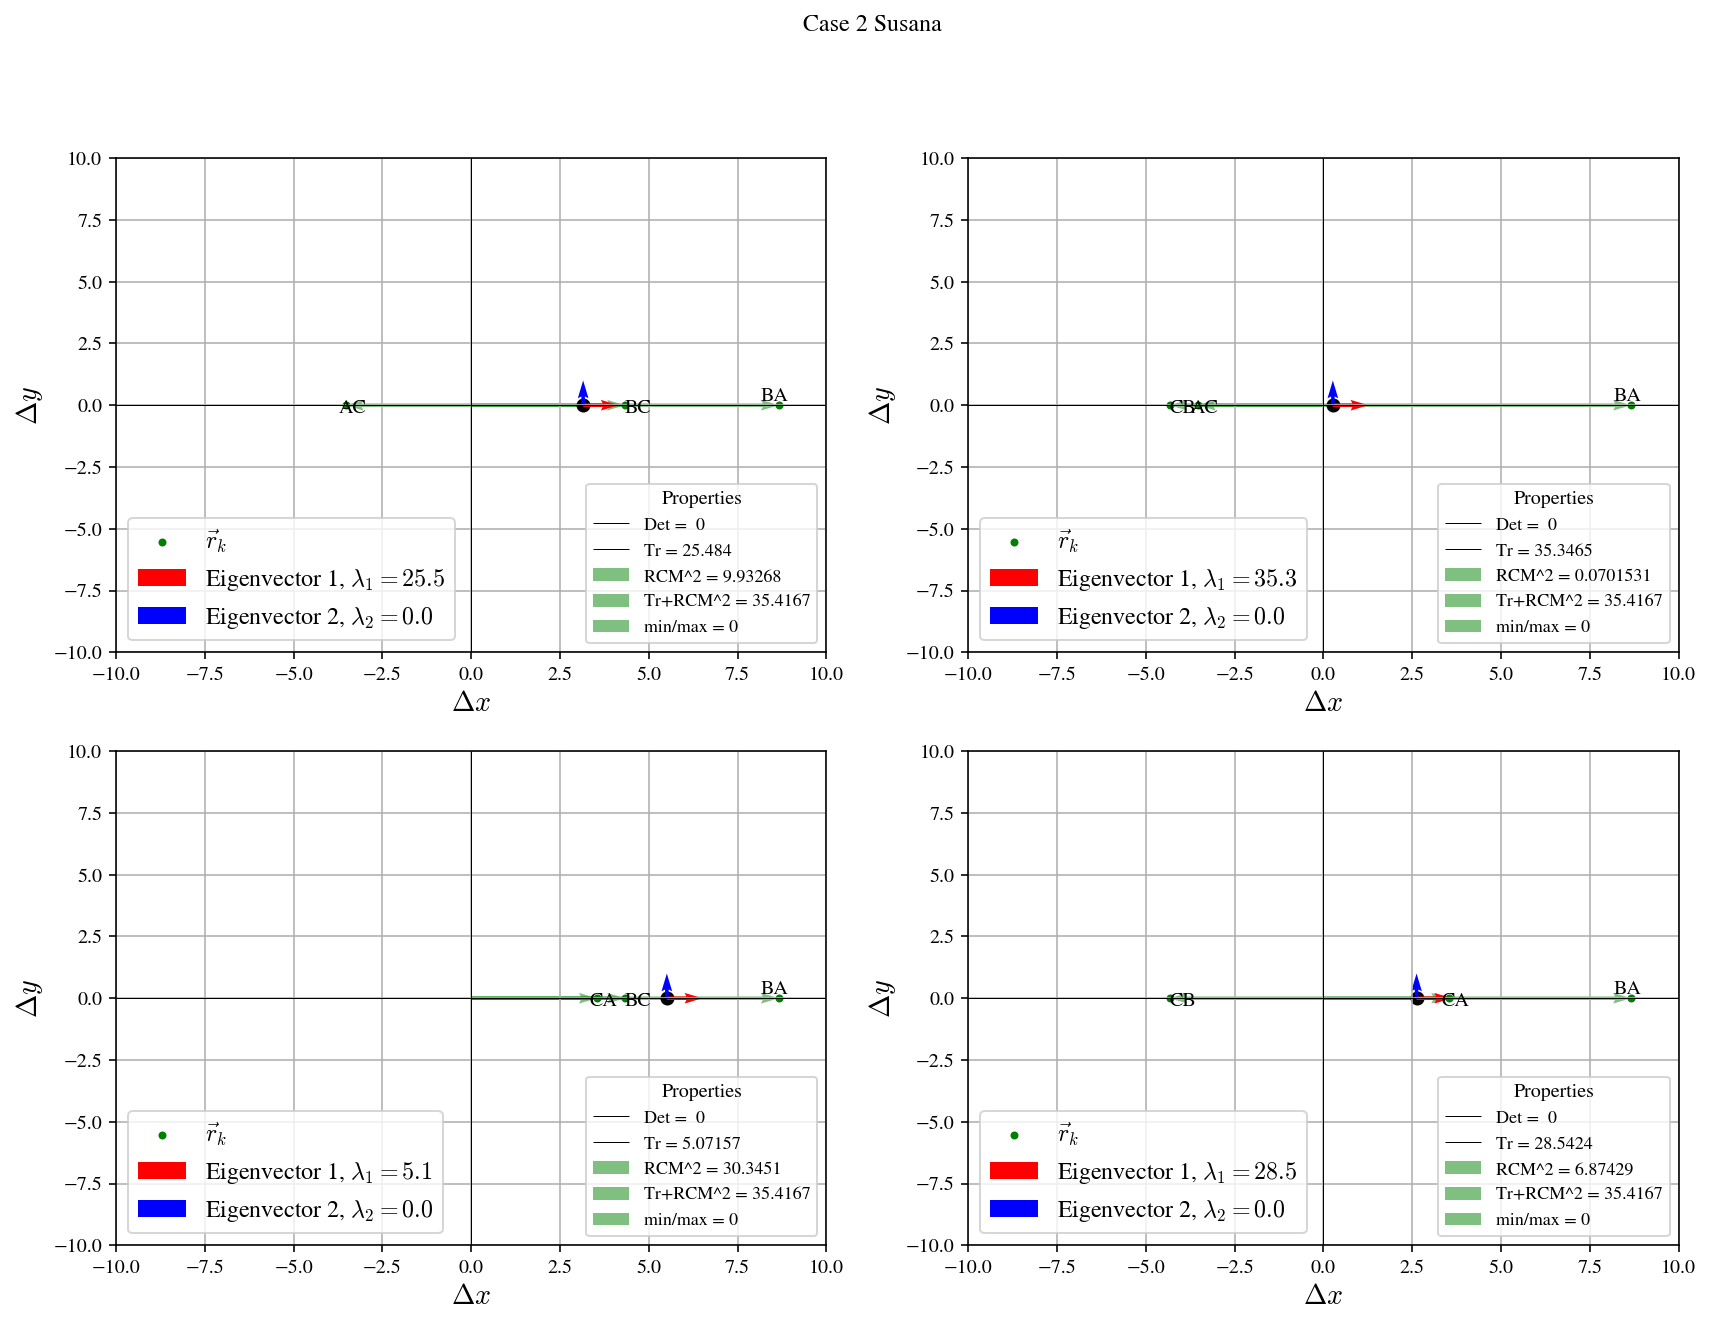

In [13]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, 0.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()/3
cov_C = cov_A.copy()

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title='Case 2 Susana', name_plot='susana_2')
plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title='Case 2 Susana', name_plot='susana_2', reversed=True)

# Case Susana 3

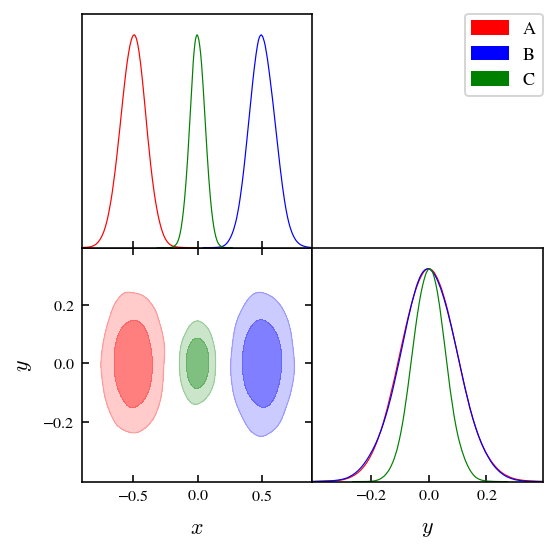

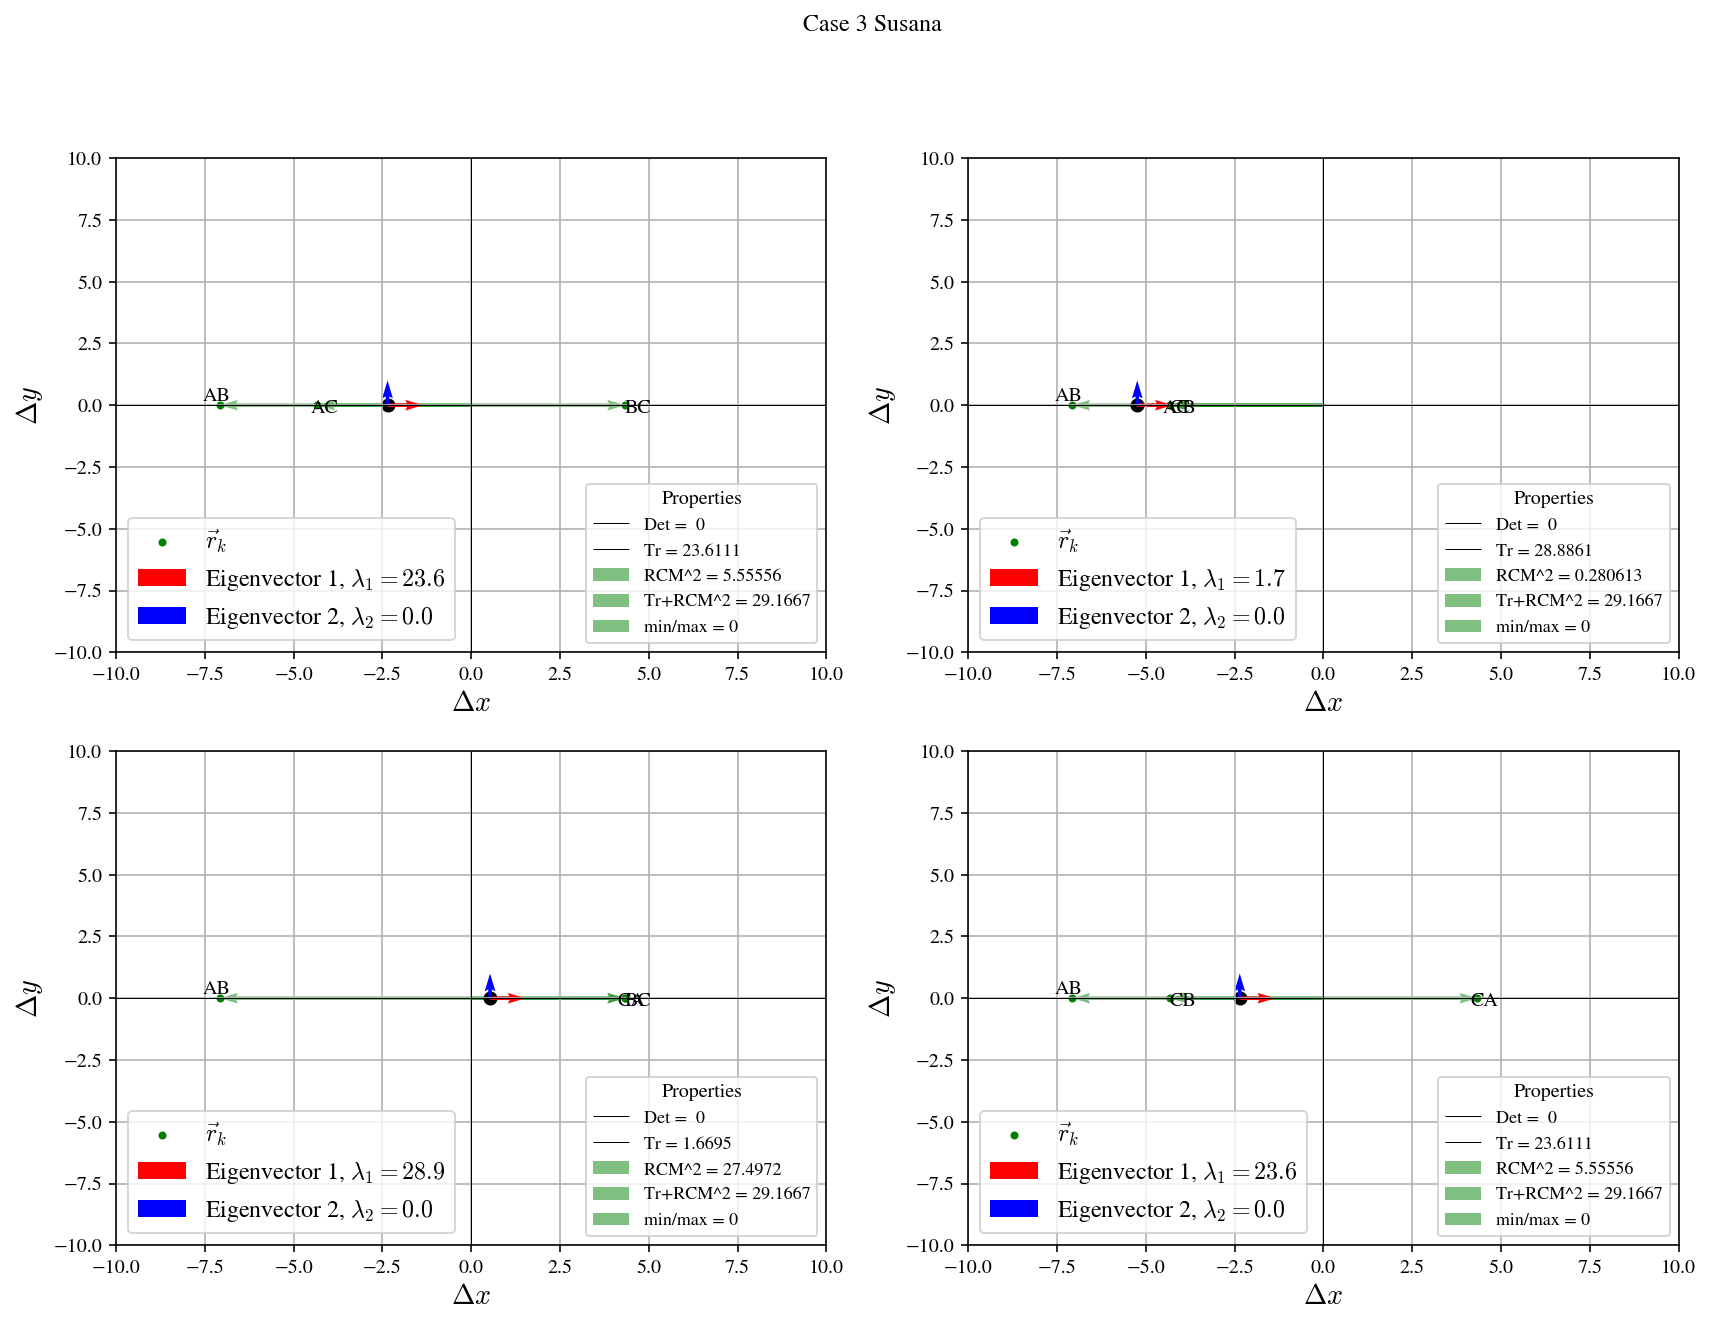

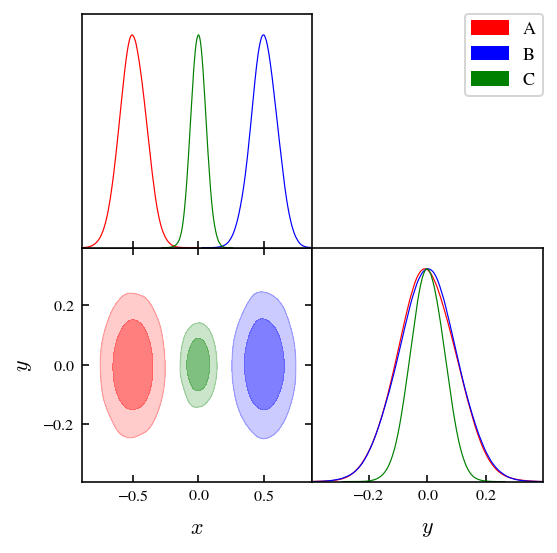

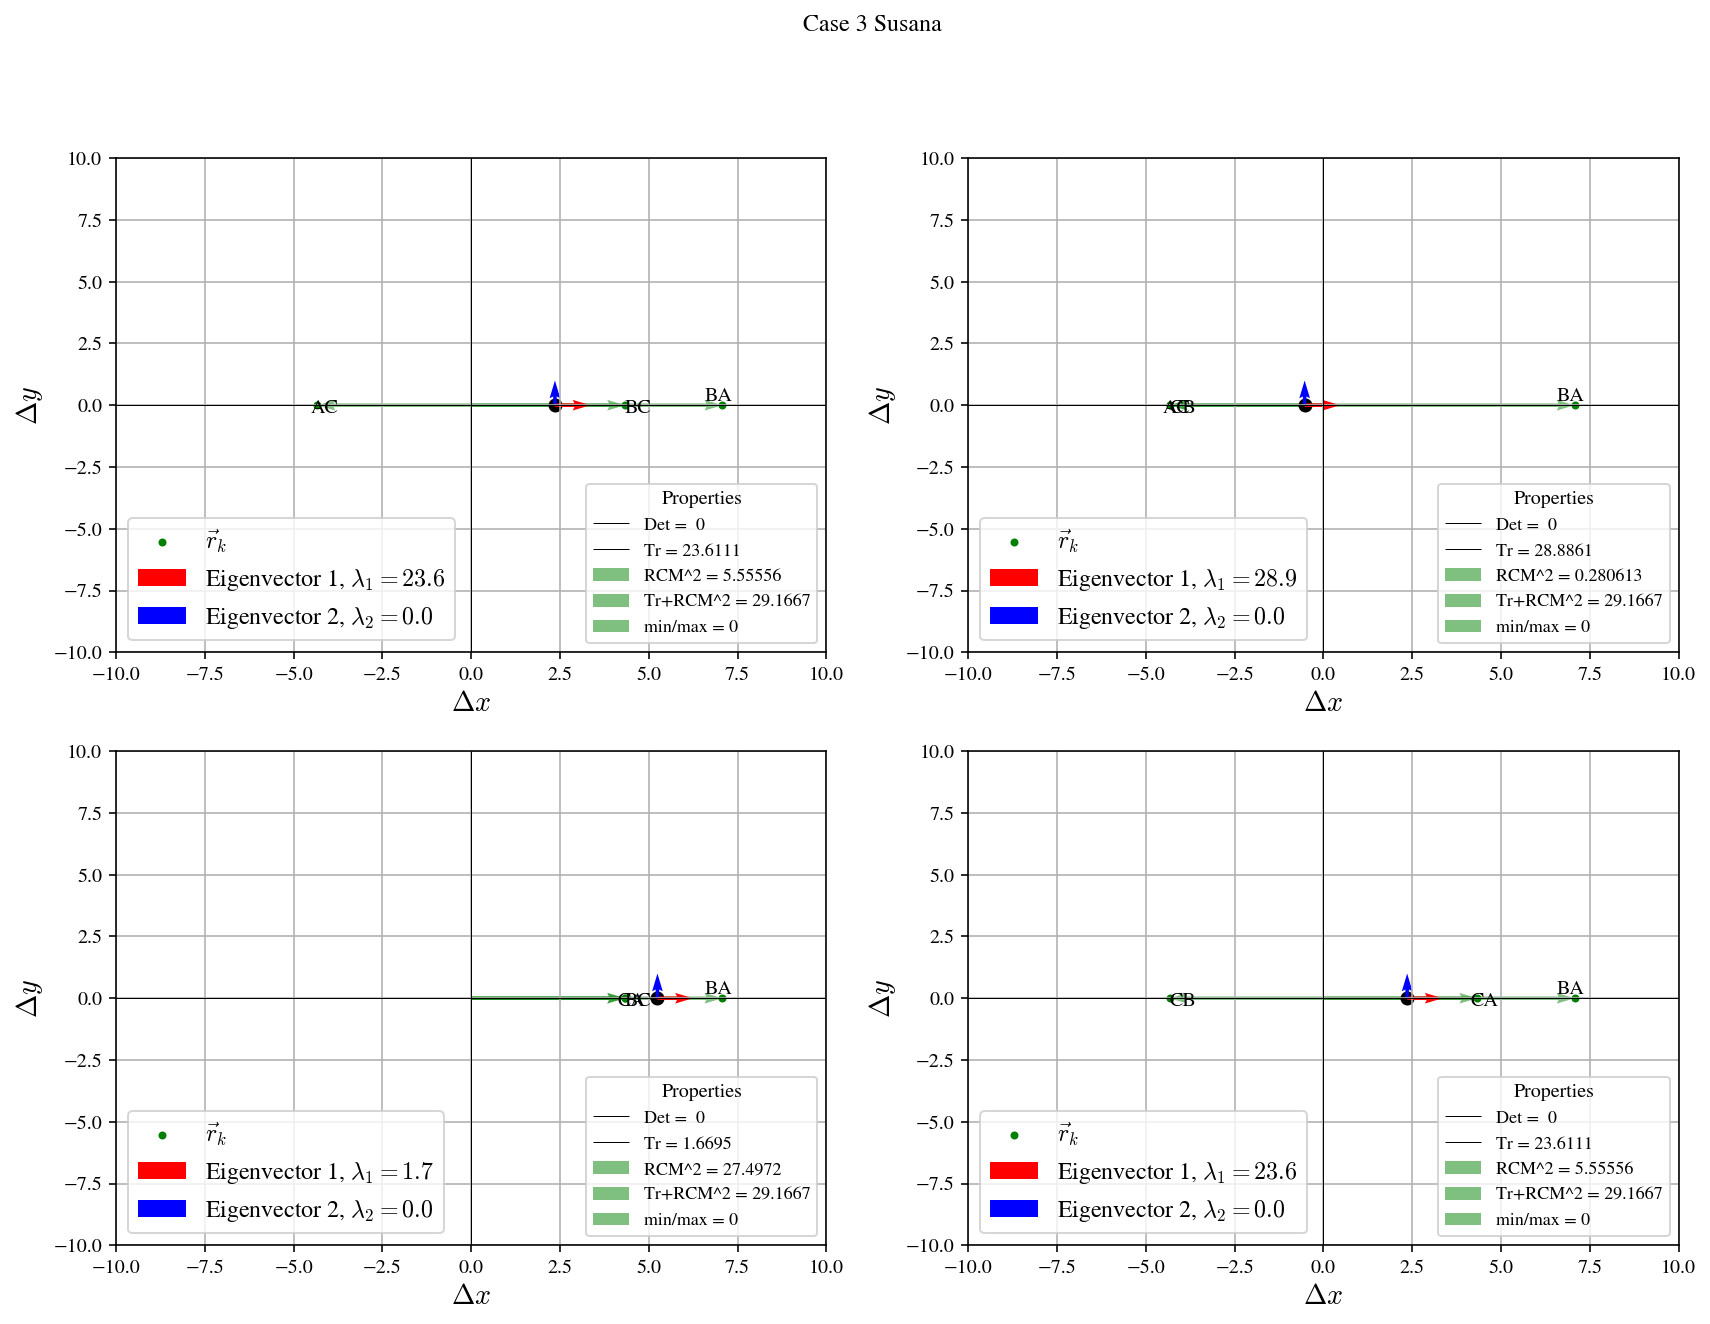

In [15]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, 0.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()/3

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title='Case 3 Susana', name_plot='susana_3')
plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title='Case 3 Susana', name_plot='susana_3', reversed=True)

# Case 3

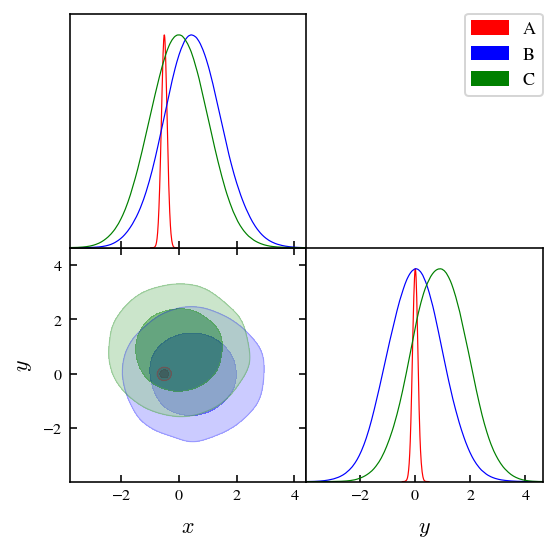

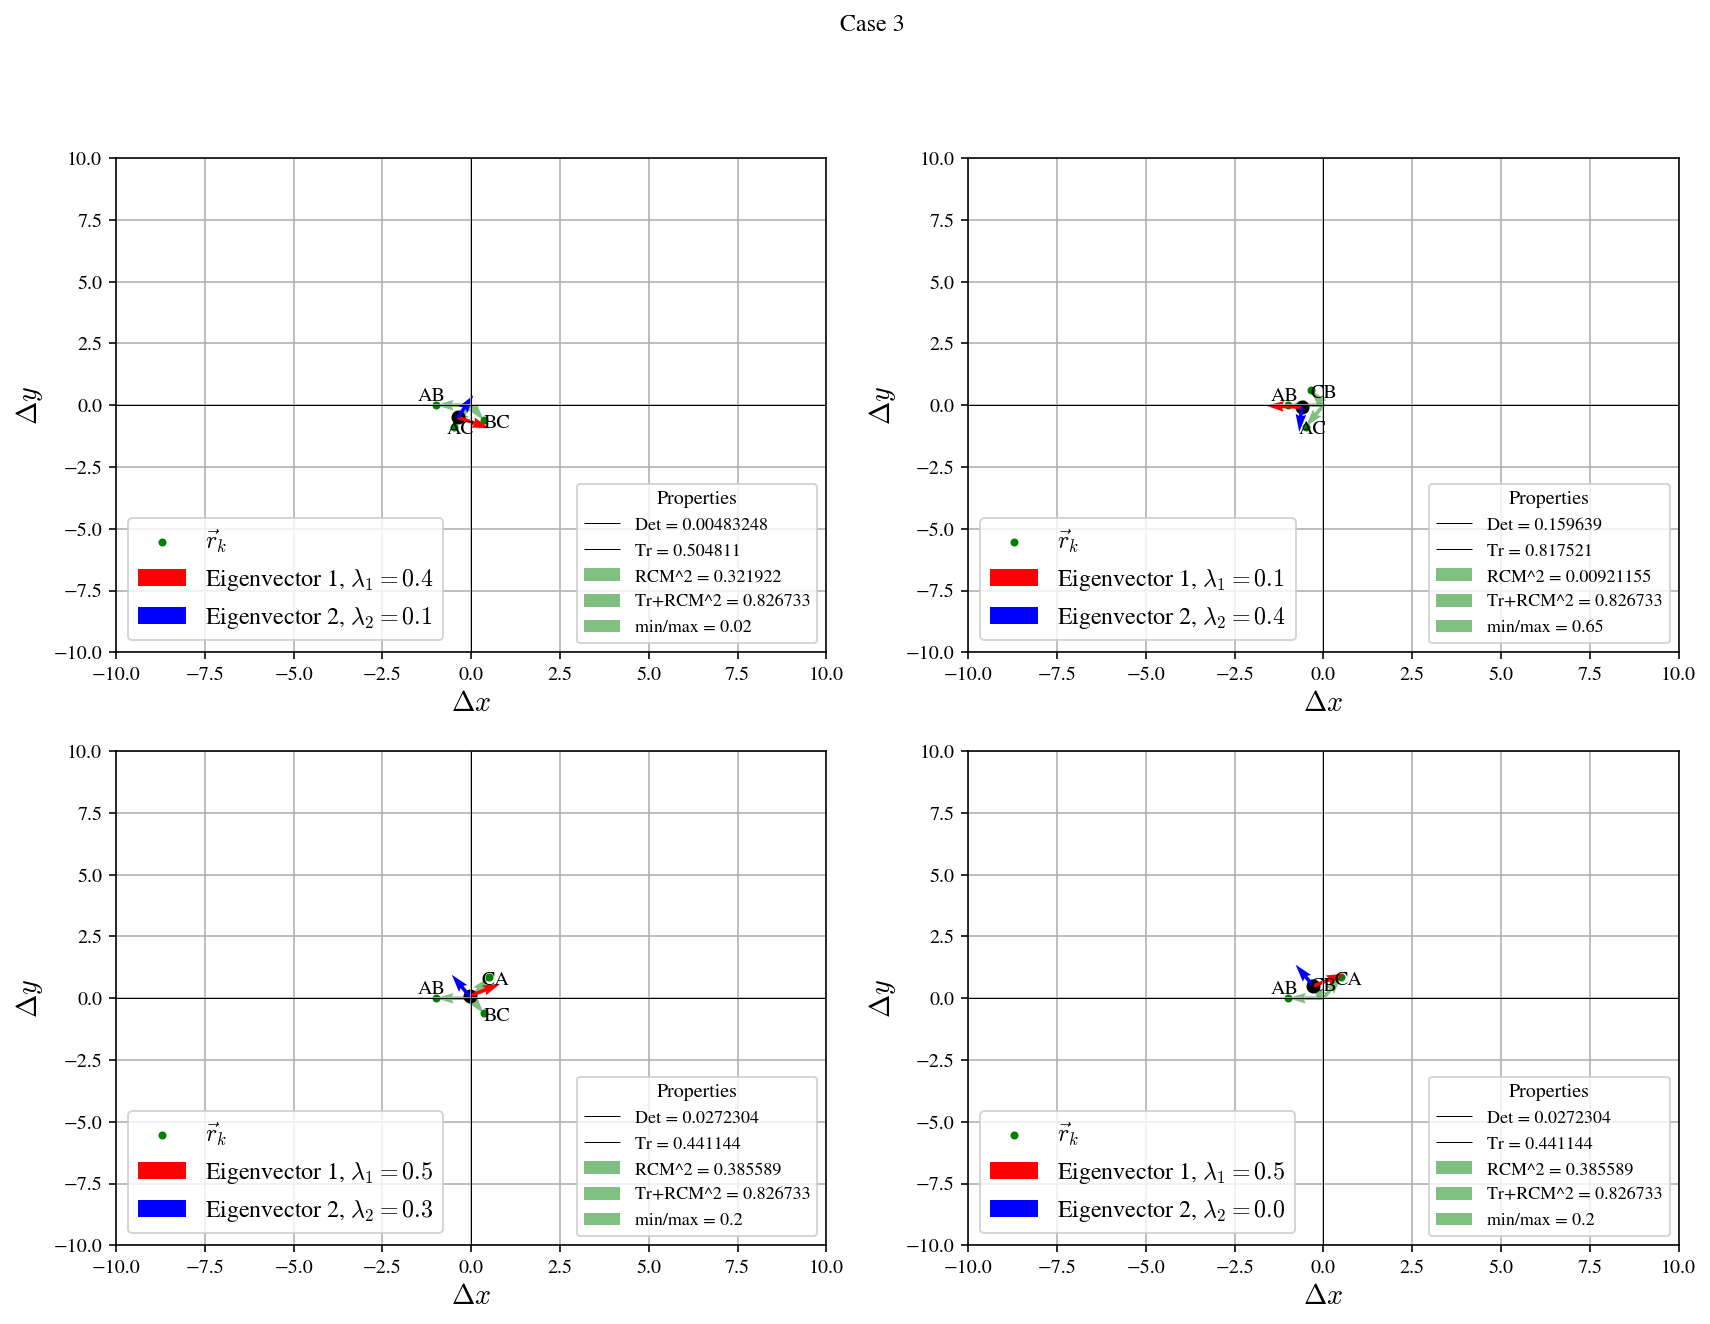

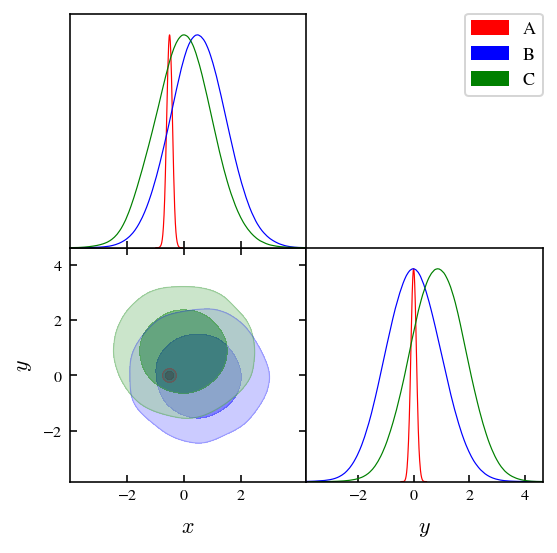

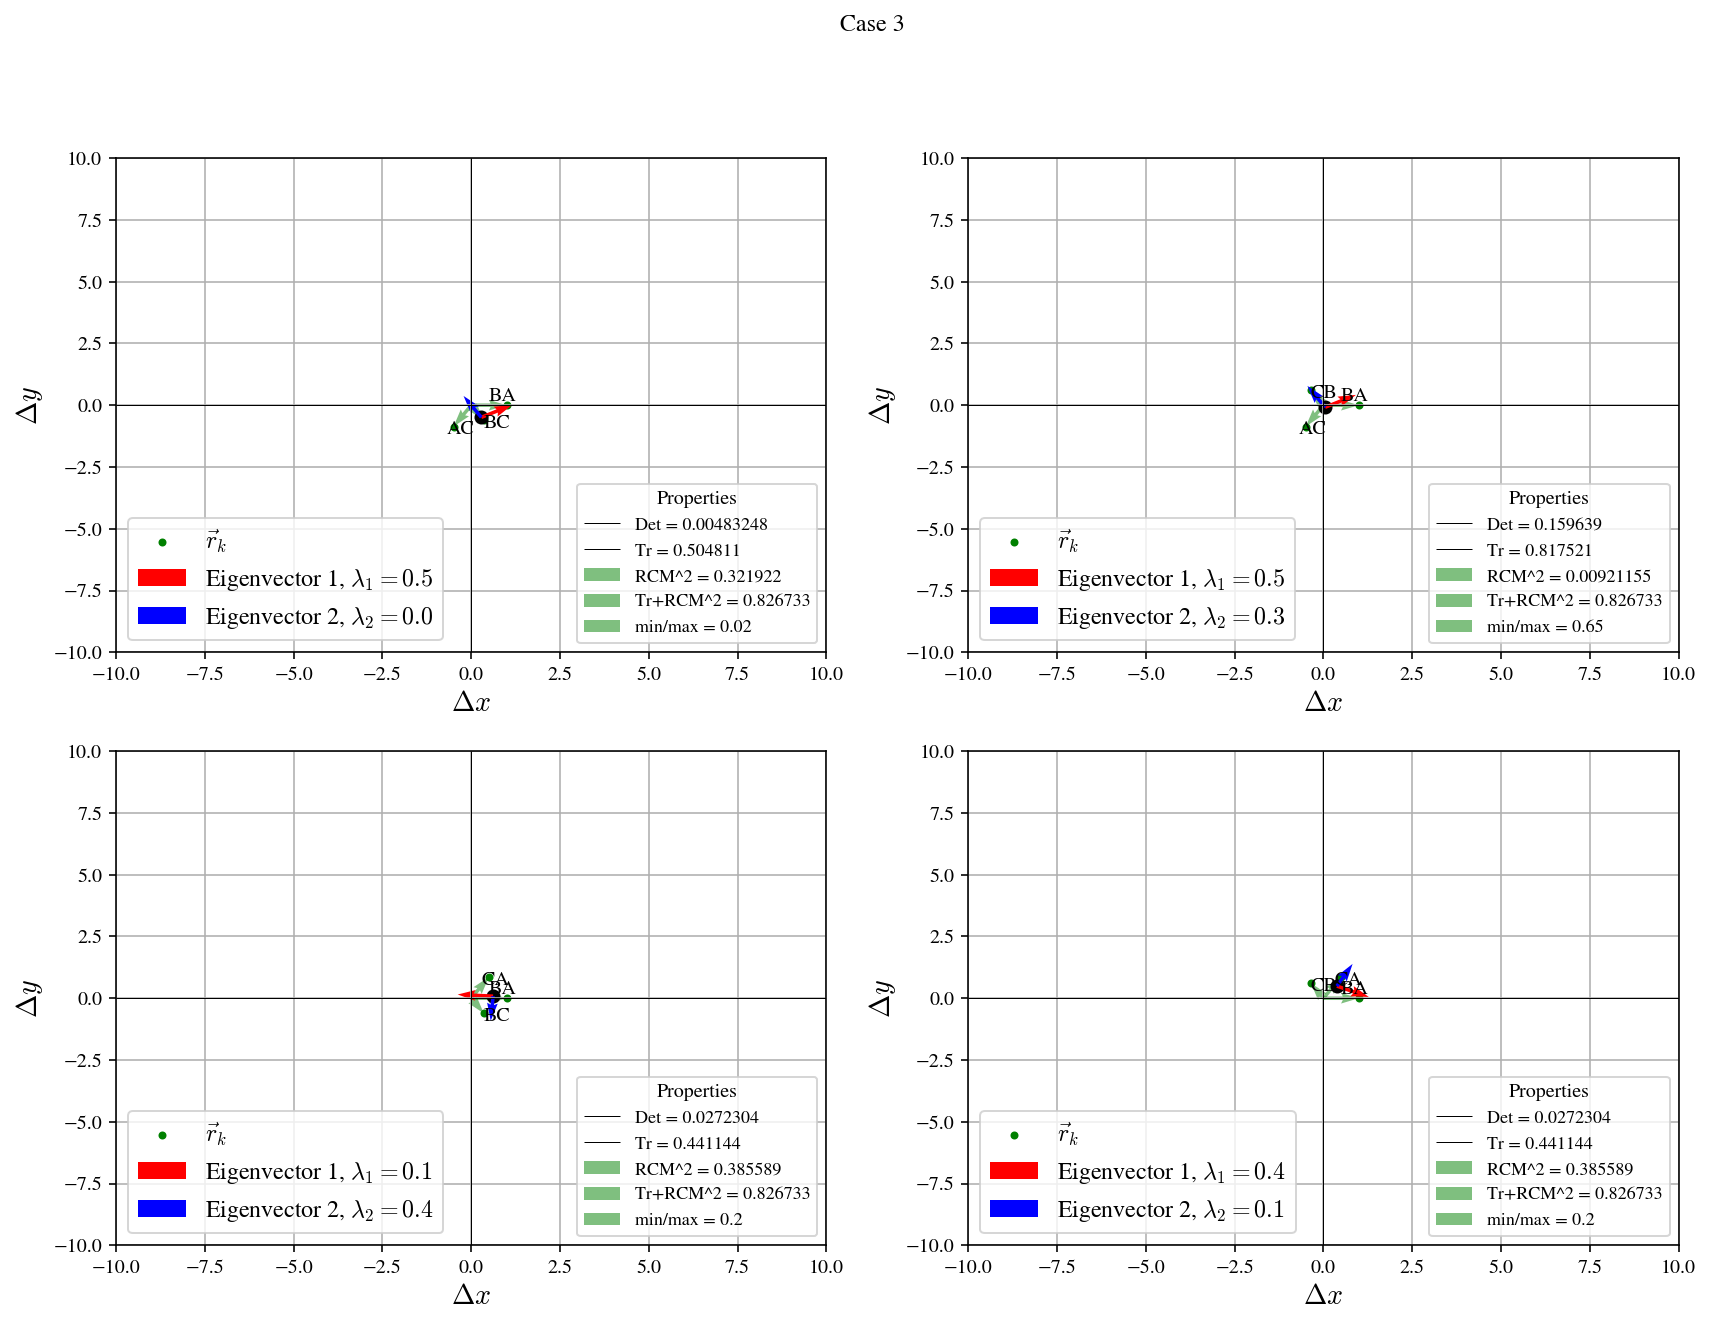

In [11]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = 100*cov_A.copy()
cov_C = 100*cov_A.copy()

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title='Case 3', name_plot='3')
plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title='Case 3', name_plot='3', reversed=True)

# Case 4

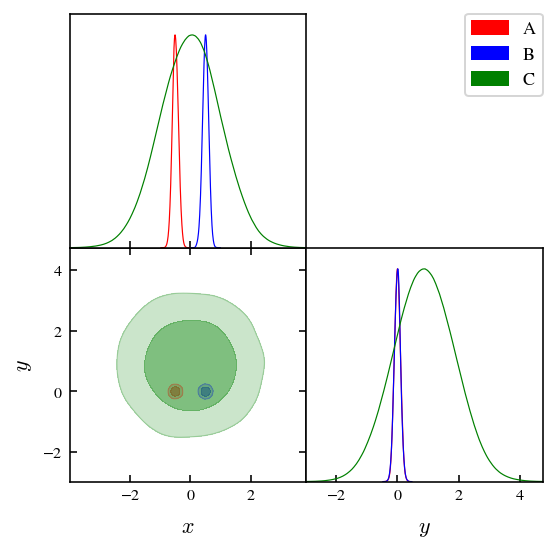

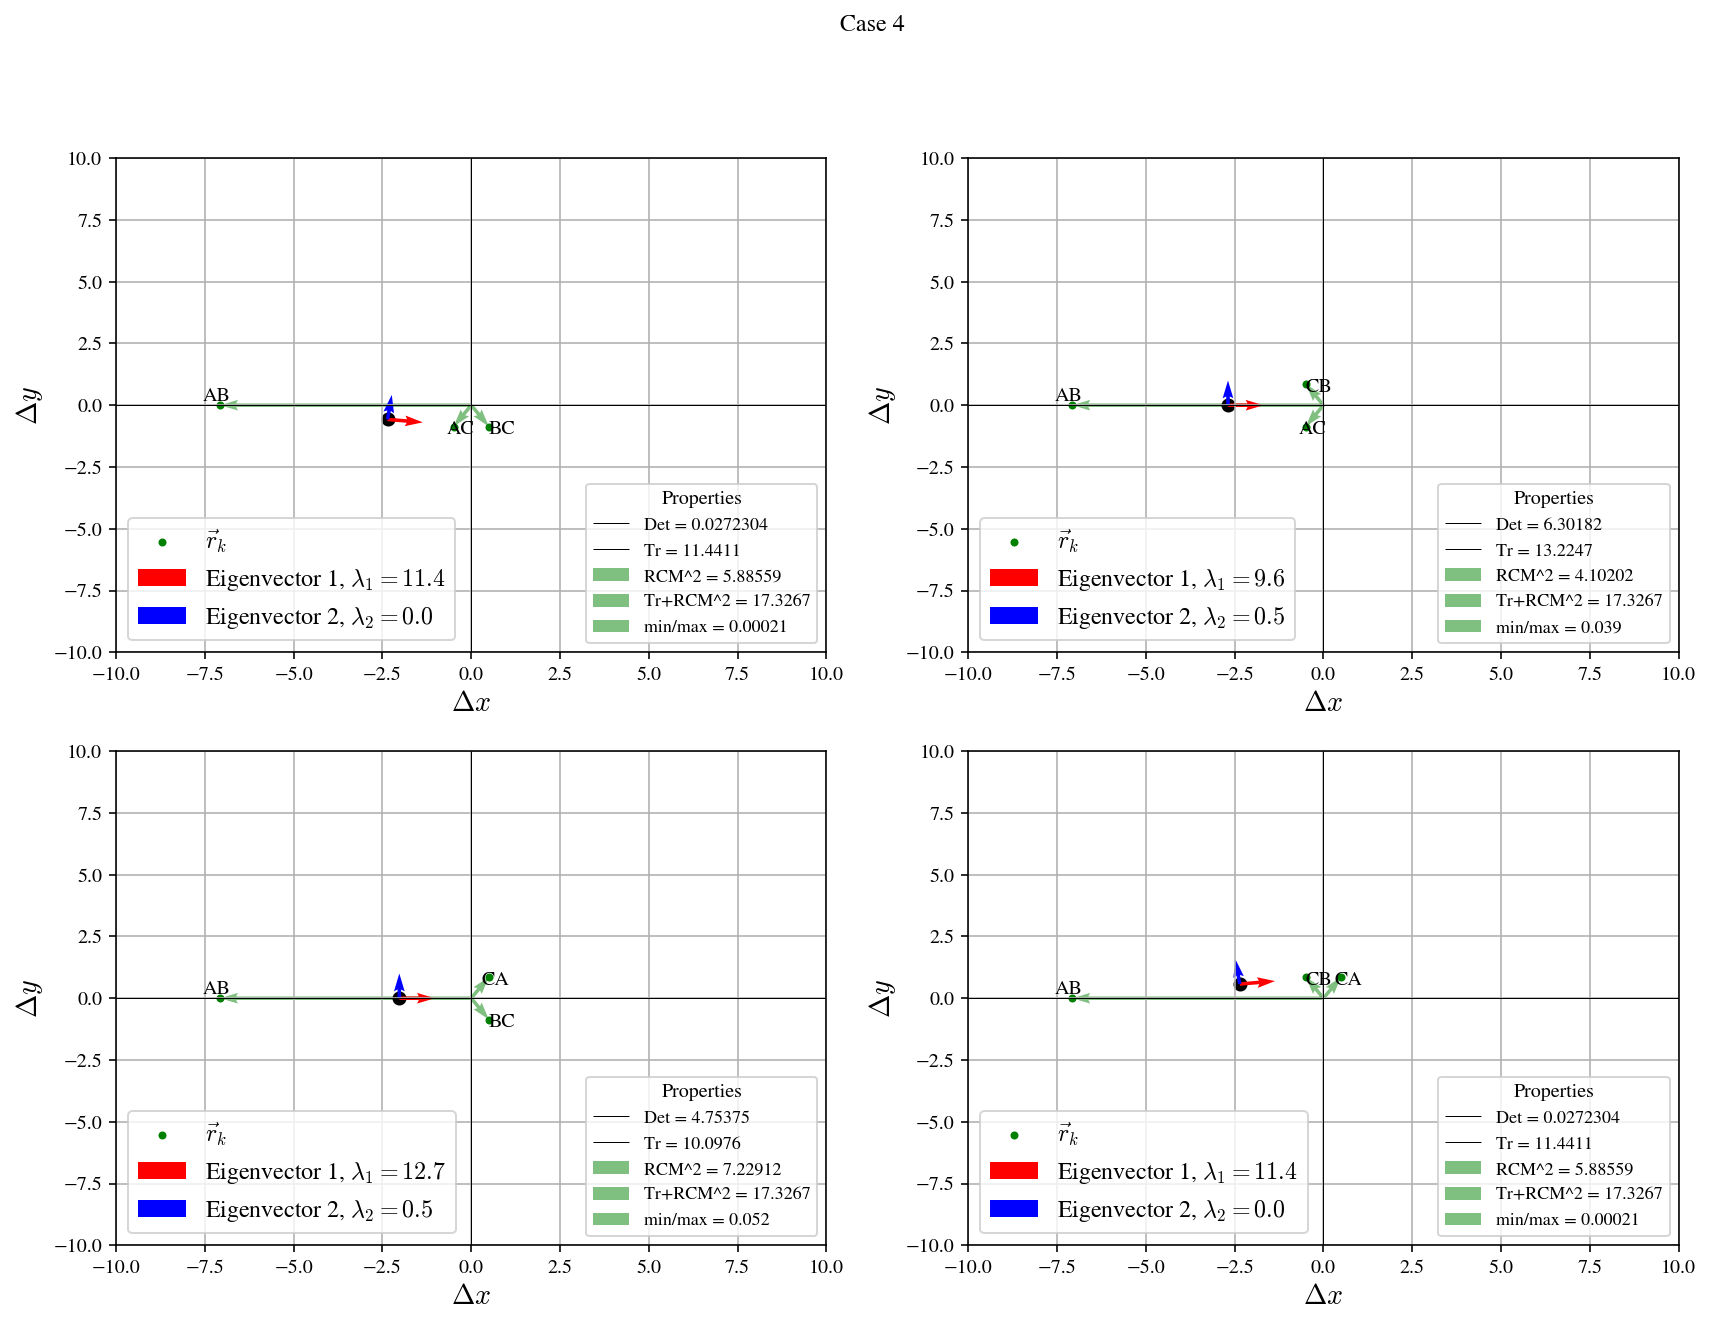

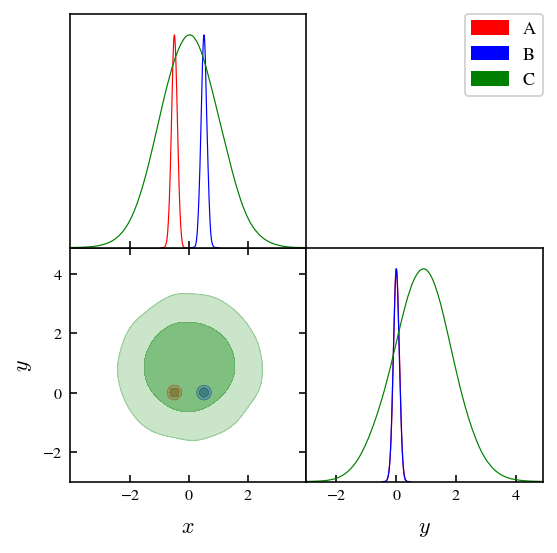

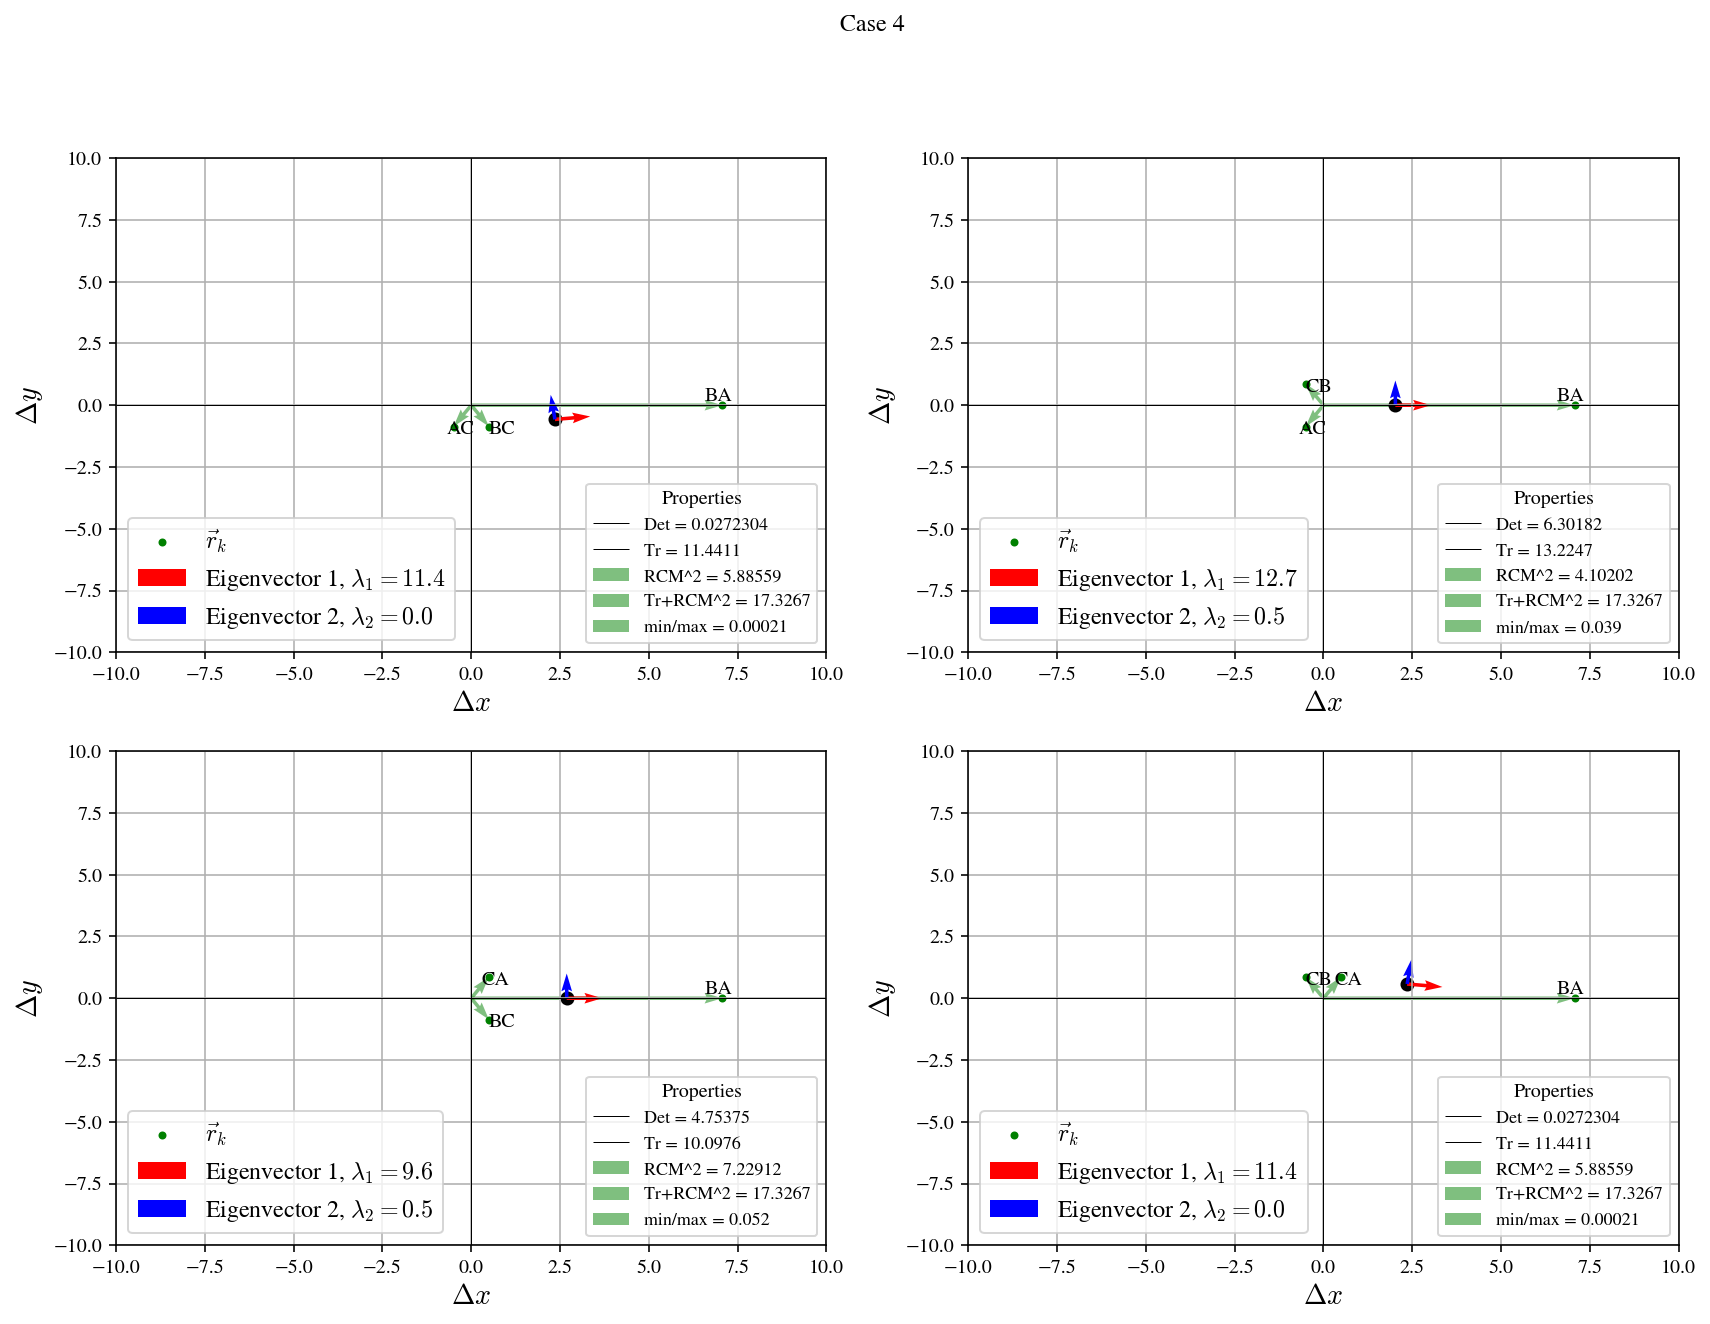

In [12]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = 100*cov_A.copy()

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title='Case 4', name_plot='4')
plot_geom(r_1, r_2, r_3, r_4, r_5, r_6, title='Case 4', name_plot='4', reversed=True)